In [1]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch
from sklearn.cluster import DBSCAN
import annoy
from annoy import AnnoyIndex
import os
from tqdm import tqdm
from shutil import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchvision import transforms
from PIL import Image
import pandas as pd
import umap

/Users/oscarchou/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/oscarchou/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/oscarchou/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is cu

In [1]:
import annoy
from annoy import AnnoyIndex
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
import shutil
from shutil import copy
import os

In [2]:
torch.cuda.is_available()

True

---

### T-SNE 降維 將embedding visualize
- 根據作者描述 不同集群之間的距離是沒有意義的 就代表超過一定距離他們之間就不相似
- t-sne也不能拿來找outliers，因為t-sne的公式中加了一個對稱項，某種程度上會把outliers拉近某個群裡
- t-sne會保留全部資料的結構以及局部資料的結構
- t-sne本身無法針對新進資料做計算，如果新進資料也要計算的話，整個演算法必需重新執行。
- 原始空間上的歐氏距離或降維之後的歐氏距離，原本距離已經有點距離的，變到t-distribution的時候會變的更遠。

### 訓練資料降維

In [4]:
#根據訓練資料 2400筆新＋舊的搭 2375舊的不搭
img_embedding_array = np.load("/workspace/Yude/OB file/pure_img_embedding_array.npy")
print(img_embedding_array.shape)
print(img_embedding_array)

(9550, 128)
[[ 0.12857506  0.21627337 -0.22320807 ...  0.09810041  0.2000035
  -0.03273094]
 [ 0.07729691  0.13296011 -0.15841806 ...  0.13339129  0.25744522
   0.01263581]
 [ 0.0890955   0.0604018  -0.16752279 ...  0.04728232  0.15685955
   0.02868759]
 ...
 [ 0.35648057  0.08139752  0.4502466  ... -0.22442307 -0.36178926
   0.25617355]
 [ 0.07938258  0.07854643 -0.25015438 ...  0.09195334  0.14684504
   0.03395245]
 [-0.56699973  0.16157487  0.23237655 ...  0.44319701  0.60666609
  -0.90876979]]


In [181]:
#perplexity:how many neighbors each point should have 5-50 are used
tsne = TSNE(n_components=2, perplexity=35, learning_rate=200)

In [182]:
embedding_tsne = tsne.fit_transform(img_embedding_array)

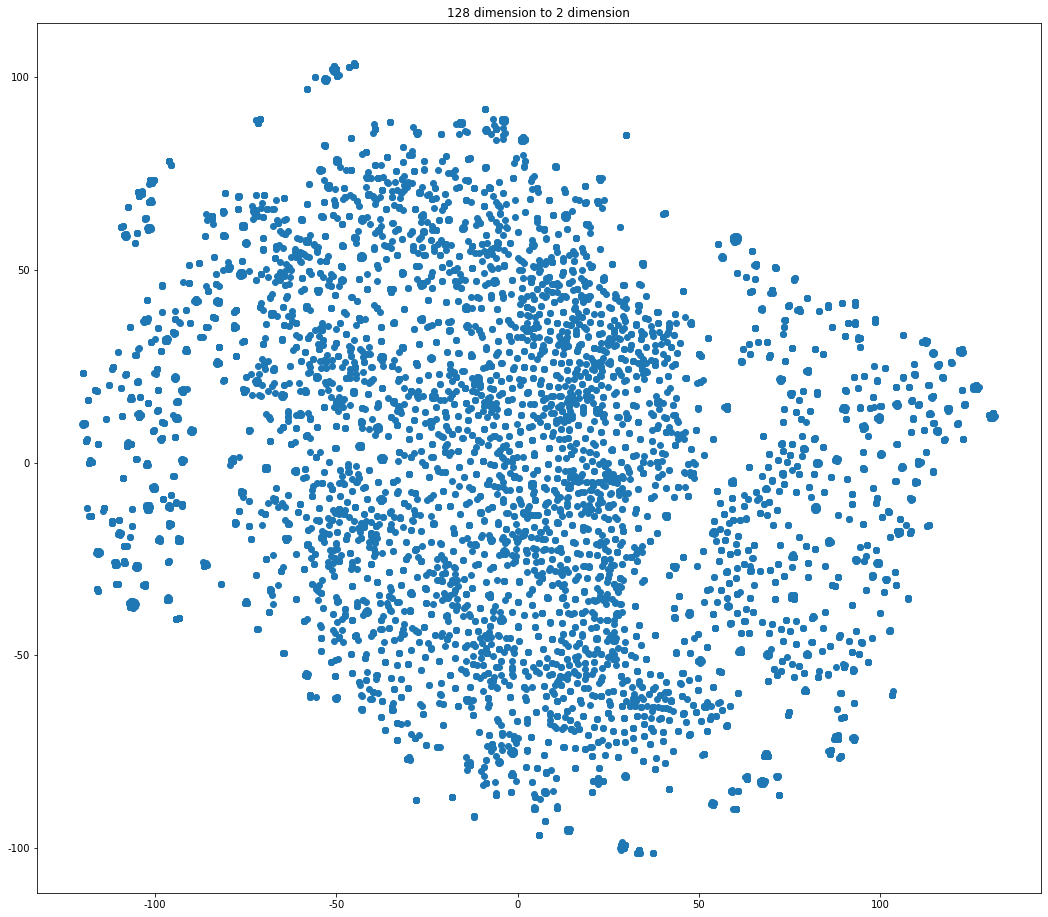

In [183]:
plt.figure(figsize=(18,16), dpi=72)
plt.title("128 dimension to 2 dimension")
plt.scatter(embedding_tsne[:, 0], embedding_tsne[:, 1])
#plt.savefig("/workspace/Yude/OB file/tsne_visualization_jpg/scatter_perplexity50.jpg")
plt.show()



### all cmap parameters
- <b>viridis</b>: A colormap that goes from dark blue to bright yellow. This is the default colormap in Matplotlib.
- <b>plasma</b>: A colormap that goes from dark blue to bright pink.
- <b>inferno</b>: A colormap that goes from dark purple to bright yellow.
- <b>magma</b>: A colormap that goes from dark purple to bright pink.
- <b>cividis</b>: A colormap that goes from dark blue to bright yellow with a wider range of colors than viridis.
- <b>Greys</b>: A grayscale colormap that goes from black to white.
- <b>Purples</b>: A colormap that goes from dark purple to bright pink.
- <b>Blues</b>: A colormap that goes from dark blue to light blue.
- <b>Greens</b>: A colormap that goes from dark green to light green.
- <b>Oranges</b>: A colormap that goes from dark orange to light orange.
- <b>Reds</b>: A colormap that goes from dark red to light red.
- <b>YlOrBr</b>: A colormap that goes from yellow to brown.
- <b>YlOrRd</b>: A colormap that goes from yellow to red.
- <b>OrRd</b>: A colormap that goes from orange to red.
- <b>PuRd</b>: A colormap that goes from purple to pink.
- <b>RdPu</b>: A colormap that goes from red to purple.
- <b>BuPu</b>: A colormap that goes from blue to purple.
- <b>GnBu</b>: A colormap that goes from green to blue.
- <b>PuBu</b>: A colormap that goes from purple to blue.
- <b>YlGnBu</b>: A colormap that goes from yellow to blue-green.
- <b>PuBuGn</b>: A colormap that goes from purple to blue-green.
- <b>viridis_r, plasma_r, inferno_r, magma_r, cividis_r, Greys_r, Purples_r, Blues_r, Greens_r, Oranges_r, Reds_r, YlOrBr_r, YlOrRd_r, OrRd_r, PuRd_r, RdPu_r, BuPu_r, GnBu_r, PuBu_r, YlGnBu_r, PuBuGn_r</b>:These are the reverse versions of the colormaps listed above. 

---

### K-Means

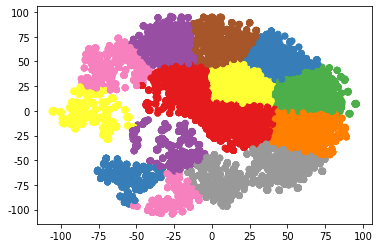

In [110]:
from sklearn.cluster import KMeans
kmeansModel = KMeans(n_clusters=15, random_state=46)
clusters_pred = kmeansModel.fit_predict(embedding_tsne)
plt.scatter(embedding_tsne.T[0], embedding_tsne.T[1], c=clusters_pred, cmap=plt.cm.Set1)


In [111]:
#各個樣本到該群的中心點的距離之平方和 越大越差
kmeansModel.inertia_

2789693.25

In [112]:
#各群的中心點
kmeansModel.cluster_centers_

array([[ 17.637032 , -12.218405 ],
       [-19.975235 ,  22.278603 ],
       [ 44.044254 ,  53.41036  ],
       [-55.631332 , -67.10086  ],
       [ 65.130585 ,  18.177965 ],
       [-27.269756 , -35.753857 ],
       [-29.701342 ,  68.49046  ],
       [ 61.863503 , -21.601818 ],
       [ 20.080774 ,  27.018425 ],
       [-79.69801  ,  -1.9247377],
       [  6.087864 ,  70.99848  ],
       [-25.235355 , -88.12606  ],
       [-65.713356 ,  45.656464 ],
       [  5.215124 , -70.62401  ],
       [ 47.509544 , -57.109055 ]], dtype=float32)

---

## T-SNE

### 6004套上身跟下身

In [3]:
top_embedding_array = np.load("/workspace/Yude/OB file/6004_top_embedding_array.npy")
bottom_embedding_array = np.load("/workspace/Yude/OB file/6004_bottom_embedding_array.npy")

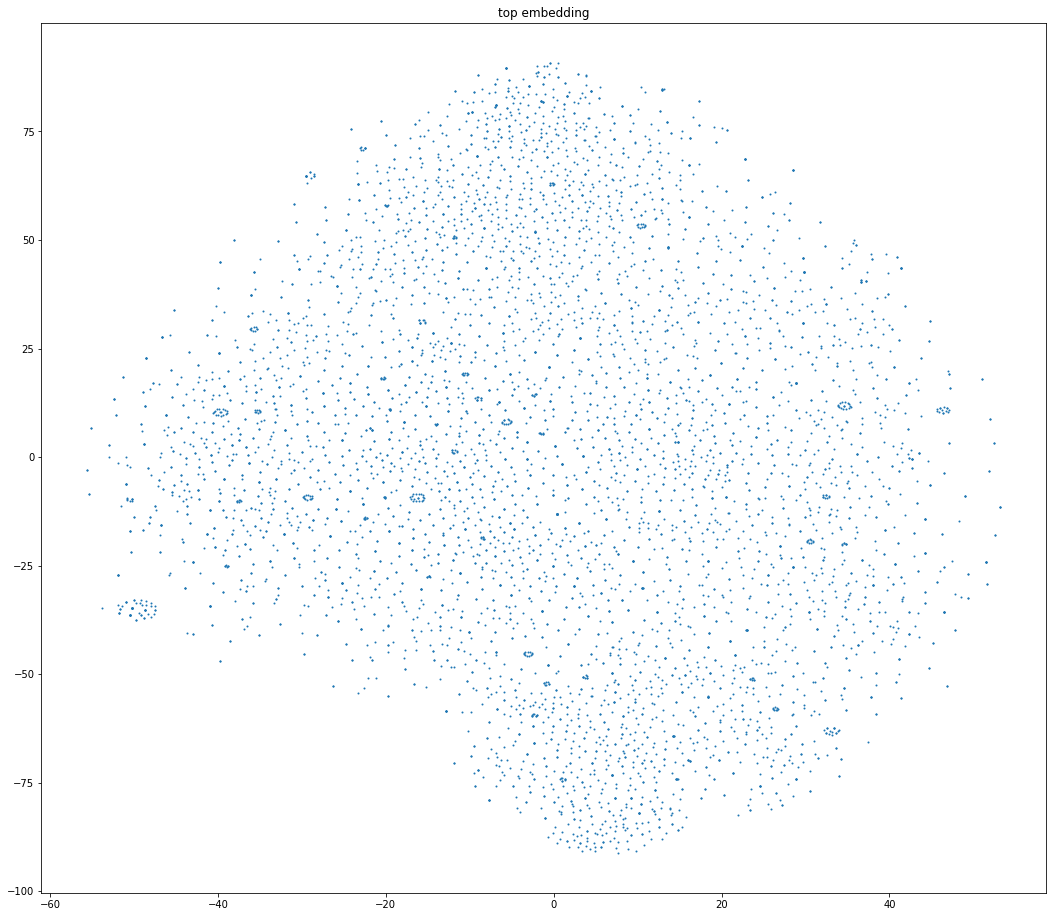

In [4]:
top_tsne = TSNE(n_components=2, perplexity=100, learning_rate=200)
top_embedding_tsne = top_tsne.fit_transform(top_embedding_array)
plt.figure(figsize=(18,16), dpi=72)
plt.title("top embedding")
plt.scatter(top_embedding_tsne[:, 0], top_embedding_tsne[:, 1], s=1)
# plt.savefig("/workspace/Yude/OB file/tsne_visualization_jpg/6004_top_perplexity100.jpg")
plt.show()


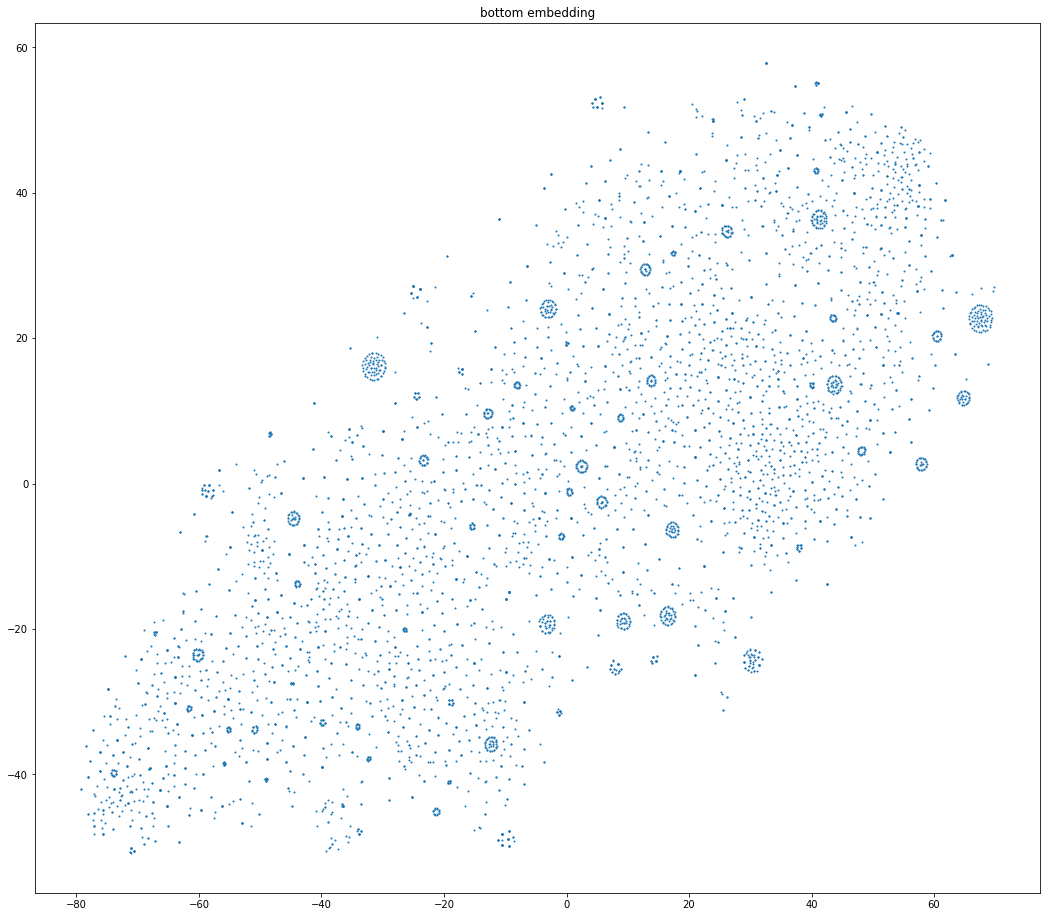

In [5]:
bottom_tsne = TSNE(n_components=2, perplexity=100, learning_rate=200)
bottom_embedding_tsne = bottom_tsne.fit_transform(bottom_embedding_array)
plt.figure(figsize=(18,16), dpi=72)
plt.title("bottom embedding")
plt.scatter(bottom_embedding_tsne[:, 0], bottom_embedding_tsne[:, 1], s=1)
# plt.savefig("/workspace/Yude/OB file/tsne_visualization_jpg/6004_bottom_perplexity100.jpg")
plt.show()

### 5066套上身及下身

In [282]:
top_embedding_array = np.load("/workspace/Yude/OB file/5063_top_embedding_array.npy")
bottom_embedding_array = np.load("/workspace/Yude/OB file/5063_bottom_embedding_array.npy")

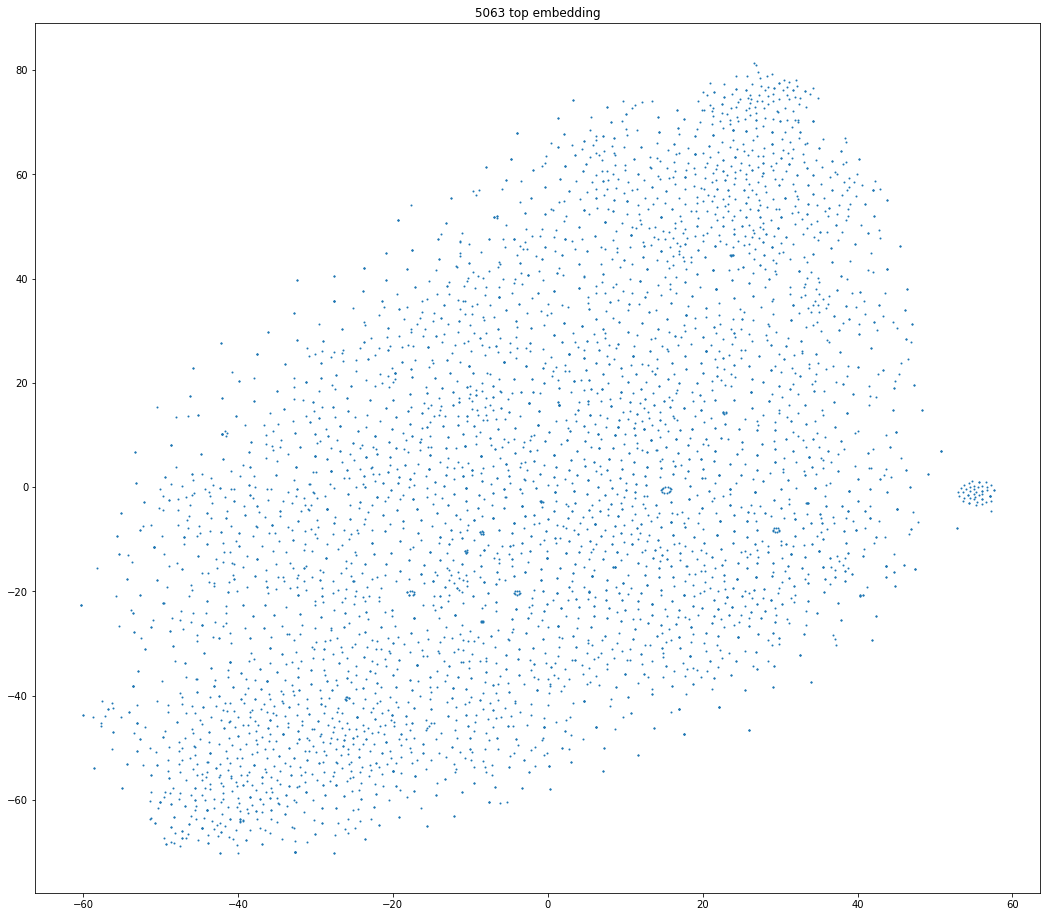

In [284]:
top_tsne = TSNE(n_components=2, perplexity=100, learning_rate=200)
top_embedding_tsne = top_tsne.fit_transform(top_embedding_array)
plt.figure(figsize=(18,16), dpi=72)
plt.title("5063 top embedding")
plt.scatter(top_embedding_tsne[:, 0], top_embedding_tsne[:, 1], s=1)
plt.savefig("/workspace/Yude/OB file/tsne_visualization_jpg/5063_top_perplexity100.jpg")
plt.show()


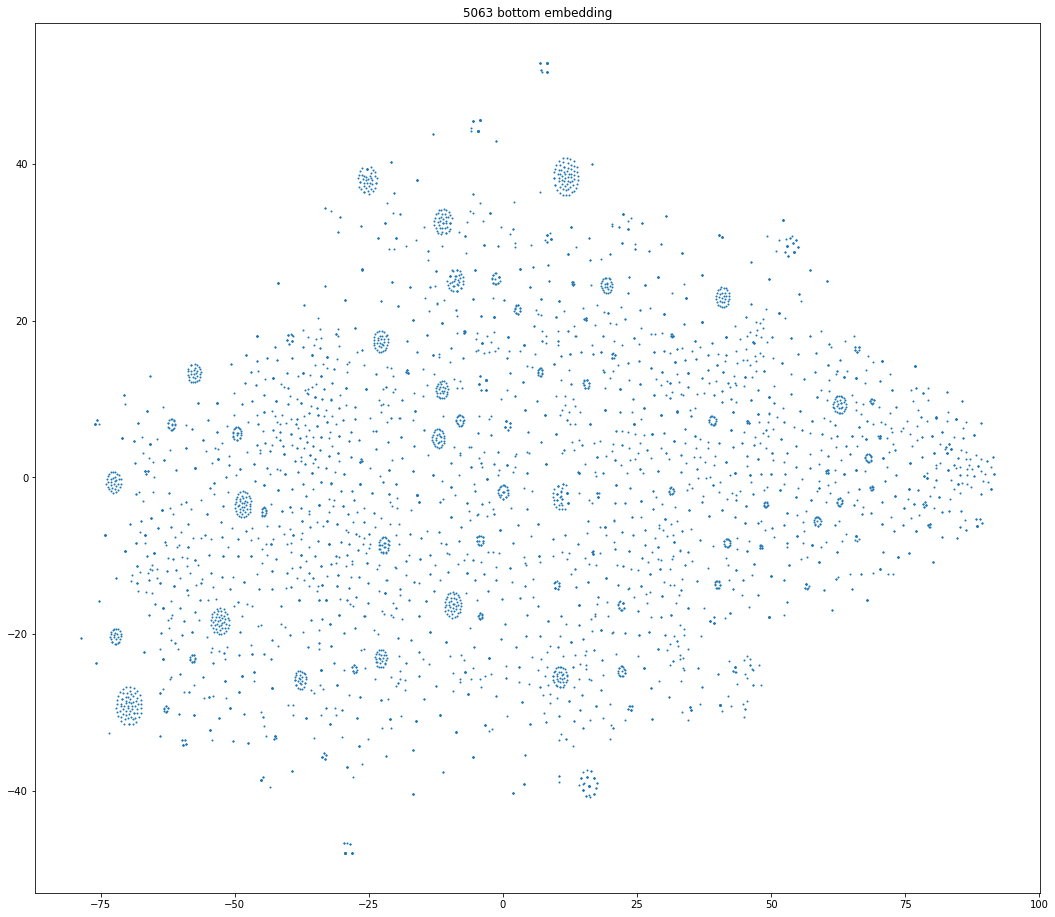

In [285]:
bottom_tsne = TSNE(n_components=2, perplexity=100, learning_rate=200)
bottom_embedding_tsne = bottom_tsne.fit_transform(bottom_embedding_array)
plt.figure(figsize=(18,16), dpi=72)
plt.title("5063 bottom embedding")
plt.scatter(bottom_embedding_tsne[:, 0], bottom_embedding_tsne[:, 1], s=1)
plt.savefig("/workspace/Yude/OB file/tsne_visualization_jpg/5063_bottom_perplexity100.jpg")
plt.show()

### 圖片加標籤訓練的模型 embedding分佈

In [8]:
top_embedding_array = np.load("img and ch label/npy file/512 tanh/m_2p5/3469_top_embedding_array.npy")
bottom_embedding_array = np.load("img and ch label/npy file/512 tanh/m_2p5/1884_bottom_embedding_array.npy")

/Users/oscarchou/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


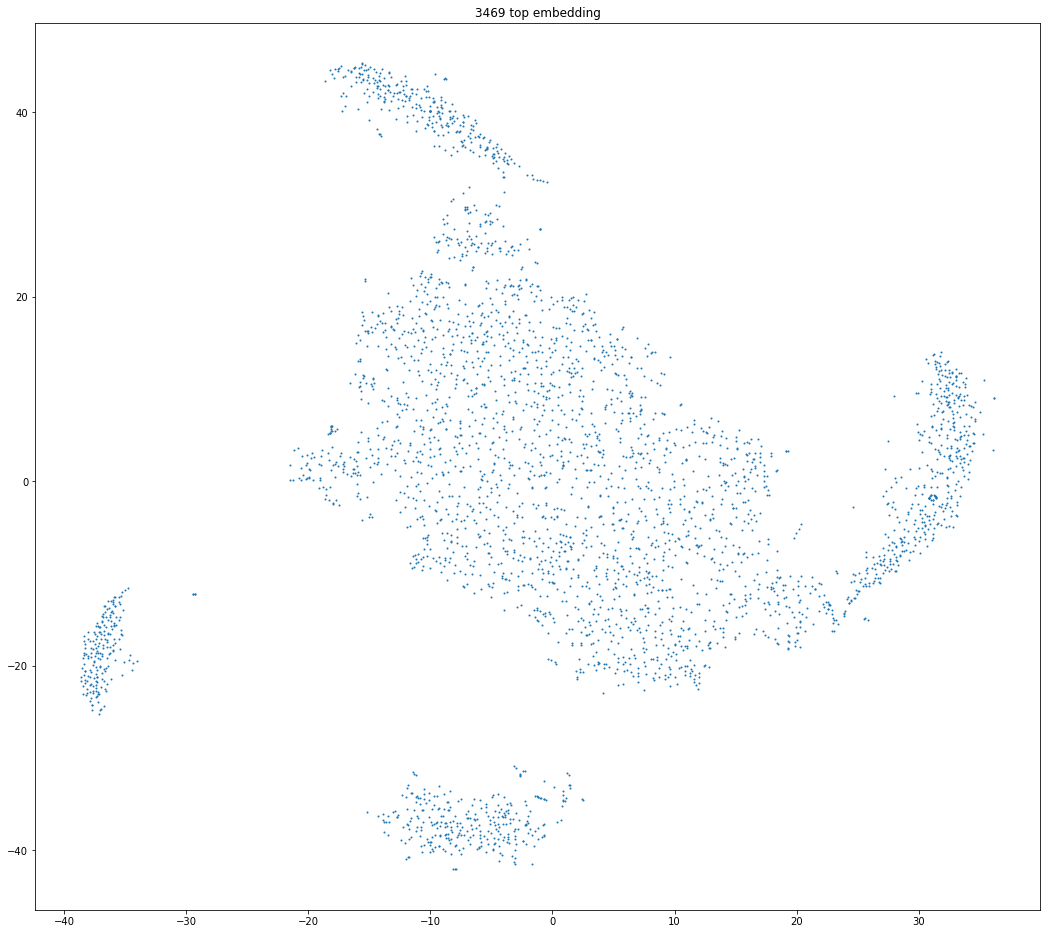

In [12]:
top_tsne = TSNE(n_components=2, perplexity=100, learning_rate=200)
top_embedding_tsne = top_tsne.fit_transform(top_embedding_array)
plt.figure(figsize=(18,16), dpi=72)
plt.title("3469 top embedding")
plt.scatter(top_embedding_tsne[:, 0], top_embedding_tsne[:, 1], s=1)
plt.show()


/Users/oscarchou/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


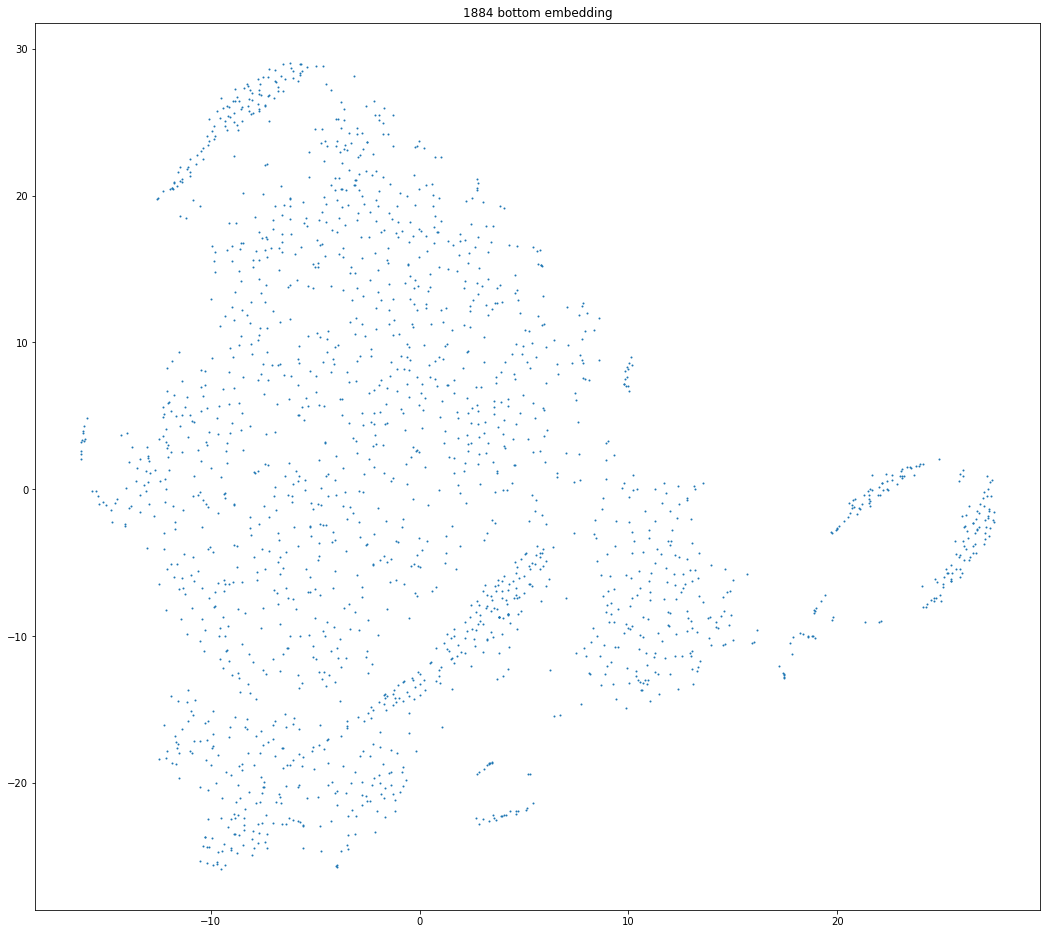

In [13]:
bottom_tsne = TSNE(n_components=2, perplexity=100, learning_rate=200)
bottom_embedding_tsne = bottom_tsne.fit_transform(bottom_embedding_array)
plt.figure(figsize=(18,16), dpi=72)
plt.title("1884 bottom embedding")
plt.scatter(bottom_embedding_tsne[:, 0], bottom_embedding_tsne[:, 1], s=1)
plt.show()


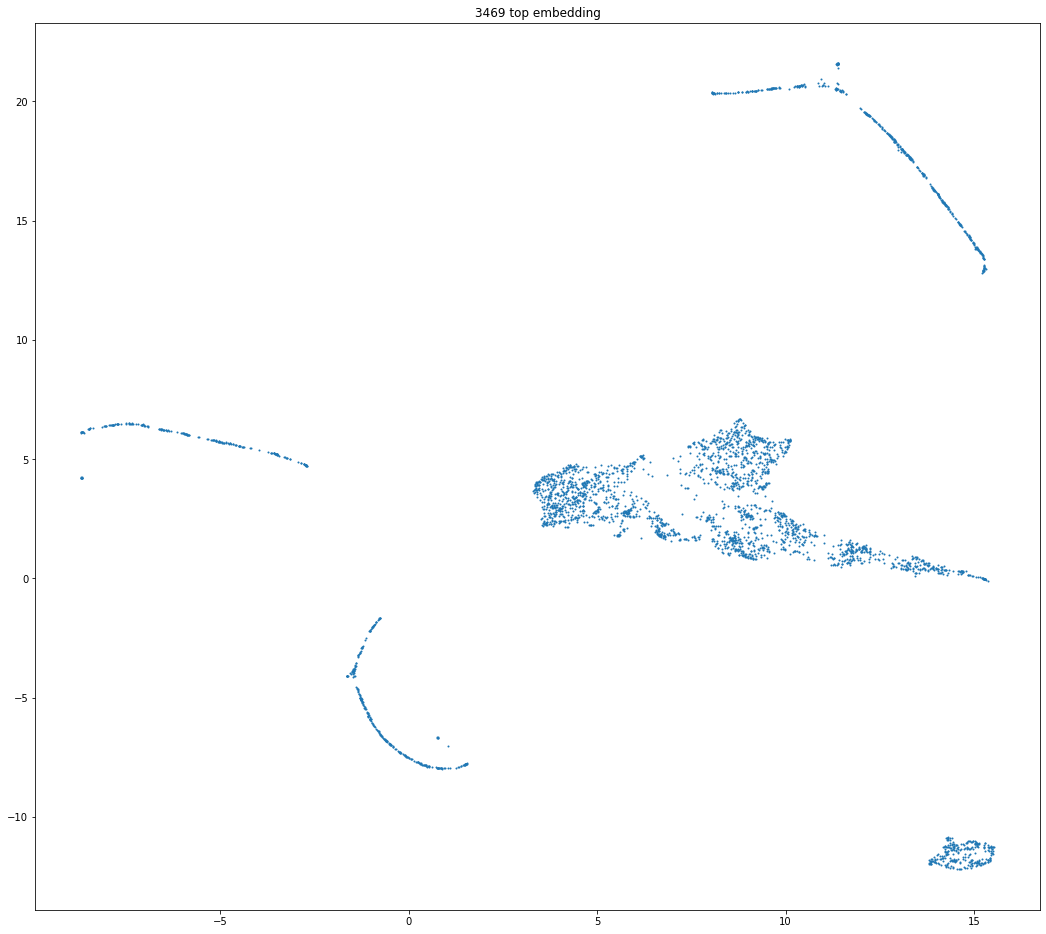

In [9]:
#umap
top_umap = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1)#min_dist 0~1
top_embedding_umap = top_umap.fit_transform(top_embedding_array)
plt.figure(figsize=(18,16), dpi=72)
plt.title("3469 top embedding")
plt.scatter(top_embedding_umap[:, 0], top_embedding_umap[:, 1], s=1)
plt.show()

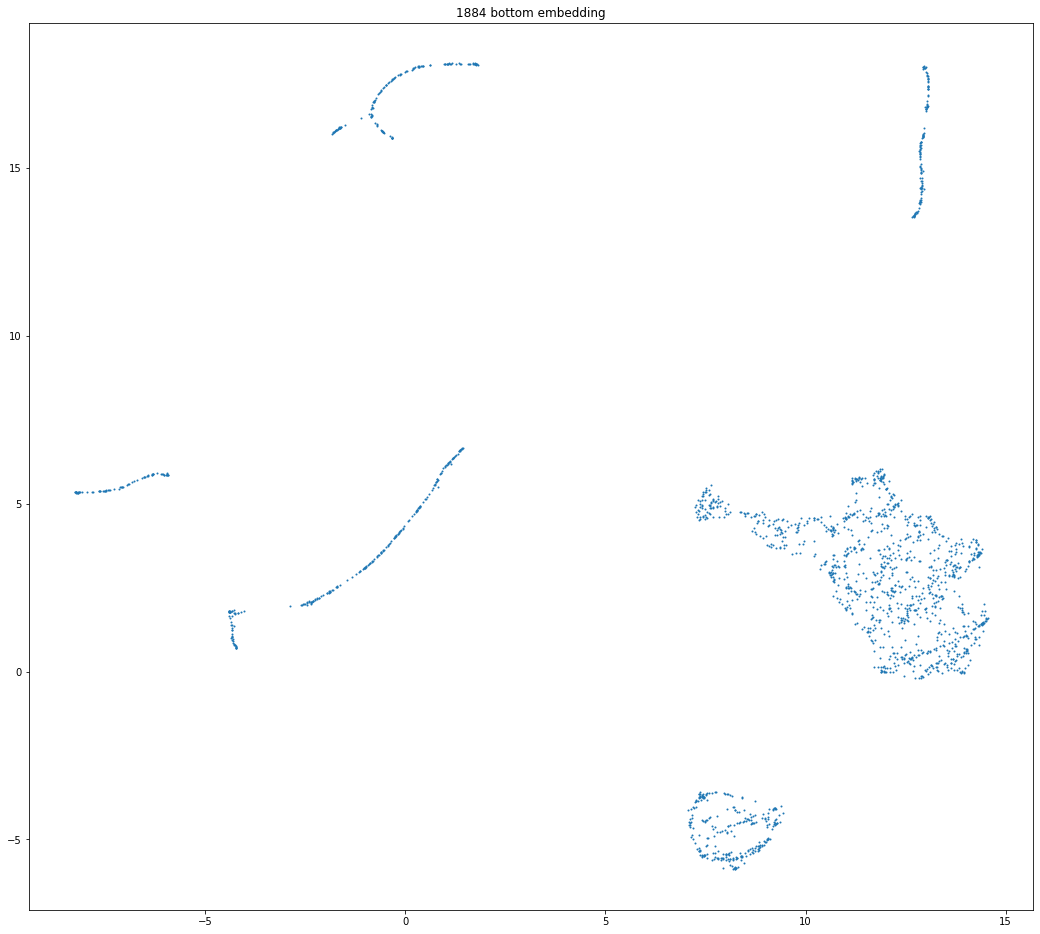

In [10]:
#umap
bottom_umap = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1)#min_dist 0~1
bottom_embedding_umap = bottom_umap.fit_transform(bottom_embedding_array)
plt.figure(figsize=(18,16), dpi=72)
plt.title("1884 bottom embedding")
plt.scatter(bottom_embedding_umap[:, 0], bottom_embedding_umap[:, 1], s=1)
plt.show()

## PCA

### 5066件上身及下身

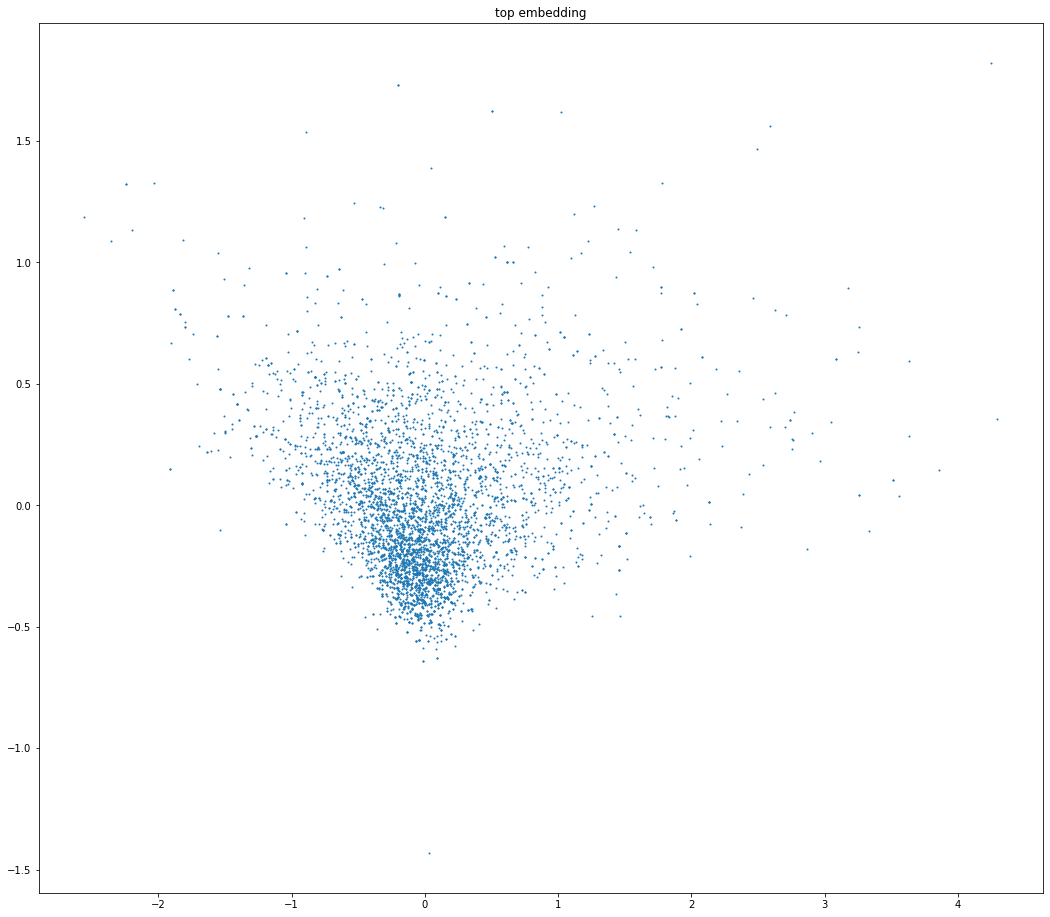

In [244]:
top_pca = PCA(n_components=2)
top_embedding_pca = top_pca.fit_transform(top_embedding_array)
plt.figure(figsize=(18,16), dpi=72)
plt.title("top embedding")
plt.scatter(top_embedding_pca[:, 0], top_embedding_pca[:, 1], s=1)
# plt.savefig("/workspace/Yude/OB file/tsne_visualization_jpg/6004_top_perplexity100.jpg")
plt.show()

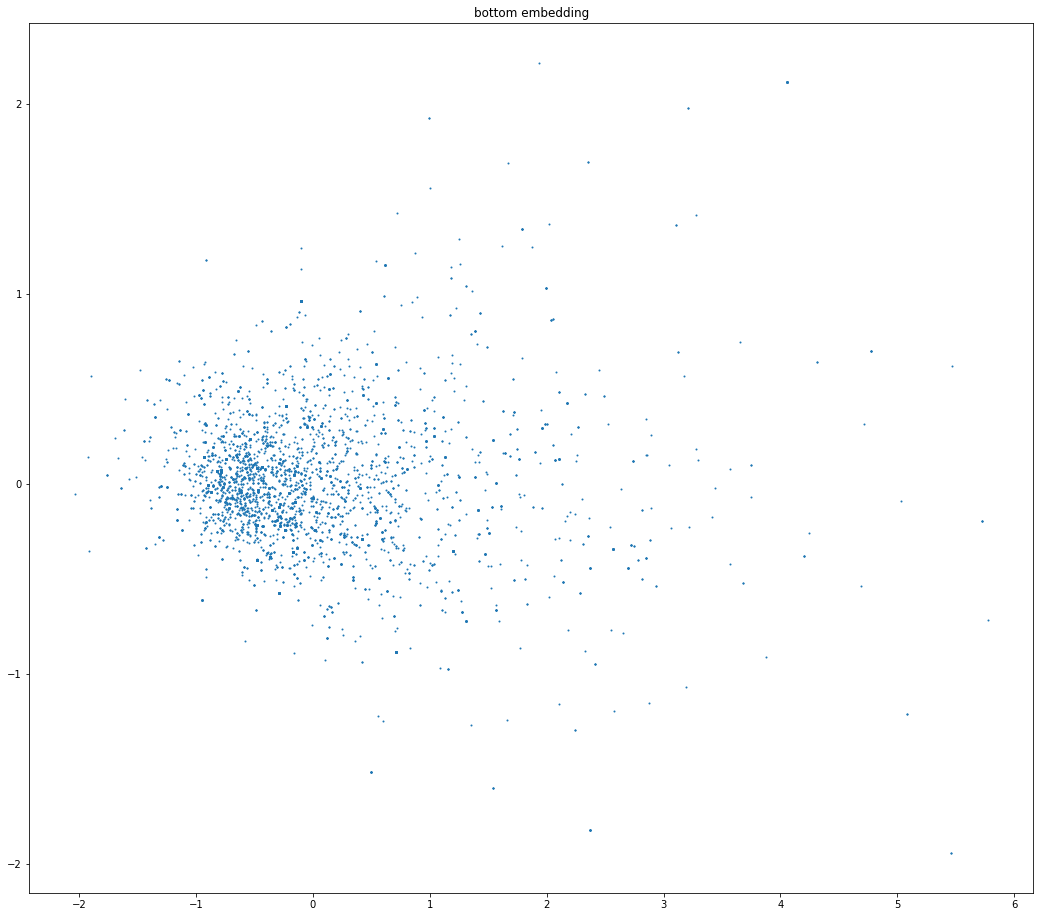

In [245]:
bottom_pca = PCA(n_components=2)
bottom_embedding_pca = bottom_pca.fit_transform(bottom_embedding_array)
plt.figure(figsize=(18,16), dpi=72)
plt.title("bottom embedding")
plt.scatter(bottom_embedding_pca[:, 0], bottom_embedding_pca[:, 1], s=1)
# plt.savefig("/workspace/Yude/OB file/tsne_visualization_jpg/6004_top_perplexity100.jpg")
plt.show()

### 3469件上身及1884件下身

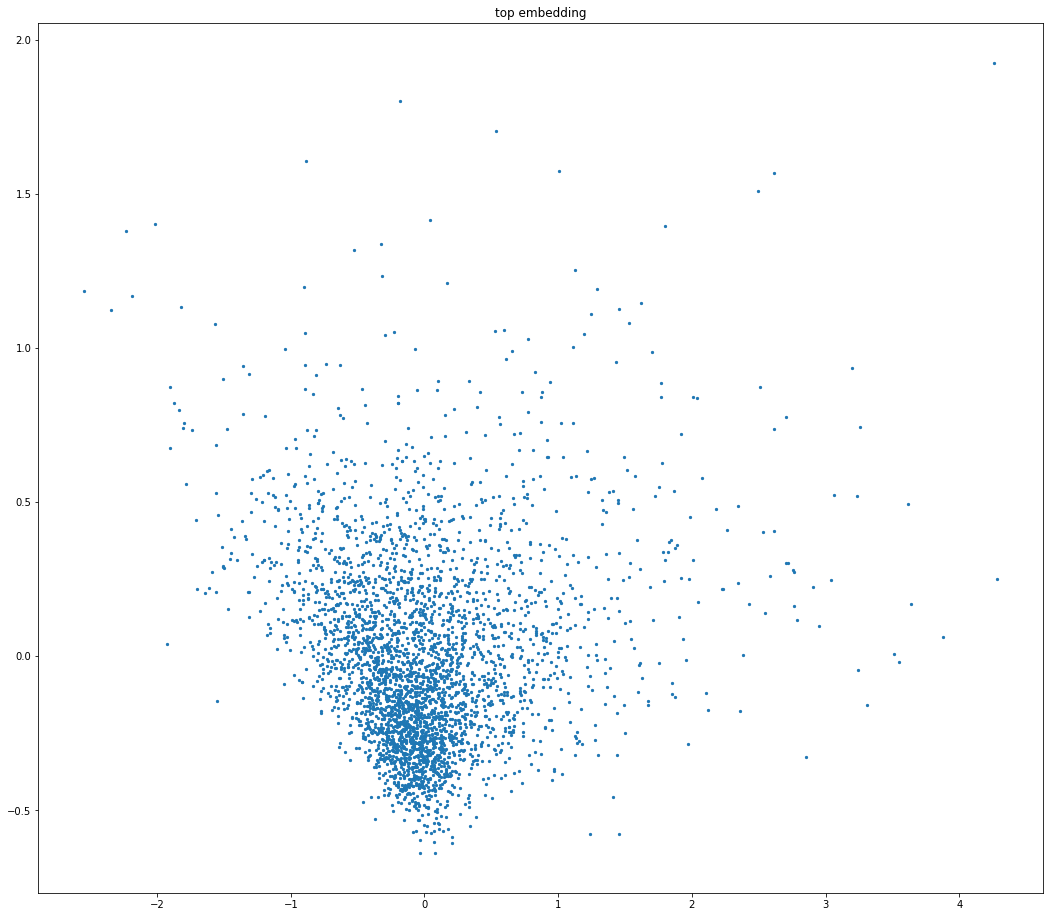

In [13]:
top_pca = PCA(n_components=2)
top_embedding_pca = top_pca.fit_transform(top_embedding_array)
plt.figure(figsize=(18,16), dpi=72)
plt.title("top embedding")
plt.scatter(top_embedding_pca[:, 0], top_embedding_pca[:, 1], s=5)
# plt.savefig("/workspace/Yude/OB file/tsne_visualization_jpg/6004_top_perplexity100.jpg")
plt.show()

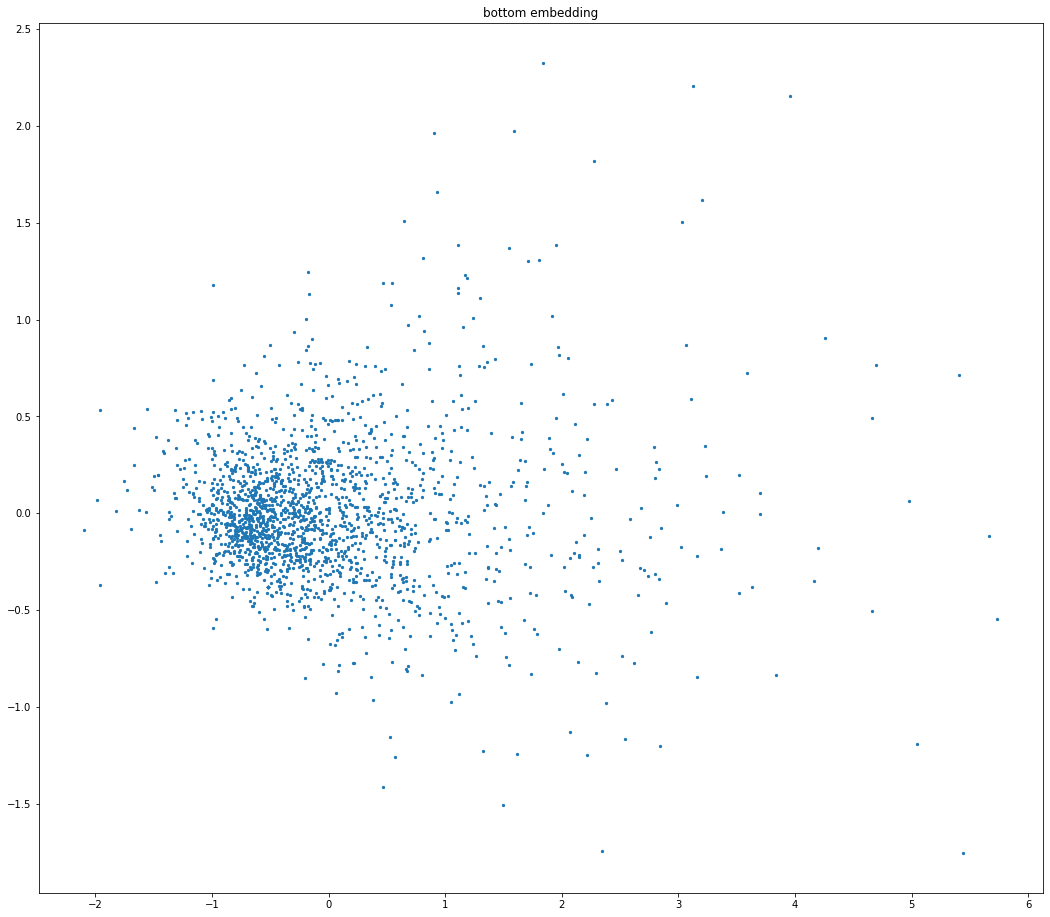

In [14]:
bottom_pca = PCA(n_components=2)
bottom_embedding_pca = bottom_pca.fit_transform(bottom_embedding_array)
plt.figure(figsize=(18,16), dpi=72)
plt.title("bottom embedding")
plt.scatter(bottom_embedding_pca[:, 0], bottom_embedding_pca[:, 1], s=5)
# plt.savefig("/workspace/Yude/OB file/tsne_visualization_jpg/6004_top_perplexity100.jpg")
plt.show()

---

## DBscan
- ε  (eps)，由這個參數值為半徑劃出的圓型區域稱為 ε-鄰域。
- minPts，構成高密度區域需要最少有幾個點。

如果 ε-鄰域裡有足夠的點（即大於等於構成高密度區域索需的最少點數），則建立一個新的聚類，否則這個點被標籤為雜訊

### 訓練資料

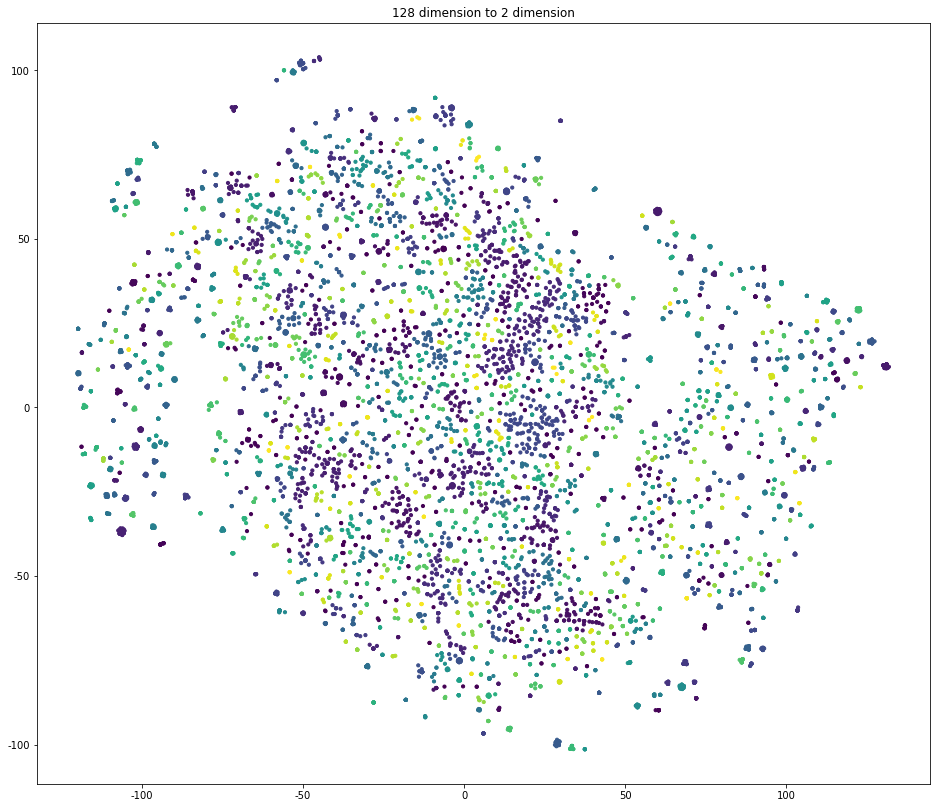

In [192]:
#根據訓練資料 2400筆新＋舊的搭 2375舊的不搭
from sklearn.cluster import DBSCAN
import numpy as np

clustering = DBSCAN(eps=2, min_samples=3).fit(embedding_tsne)
# clustering.labels_
plt.figure(figsize=(16,14), dpi=72)
plt.title("128 dimension to 2 dimension")
plt.scatter(embedding_tsne[:,0], embedding_tsne[:,1], s=10, c=clustering.labels_)
# plt.savefig("/workspace/Yude/OB file/DBscan_clustering/eps2min3.jpg")
plt.show()

### 6004套上身及下身

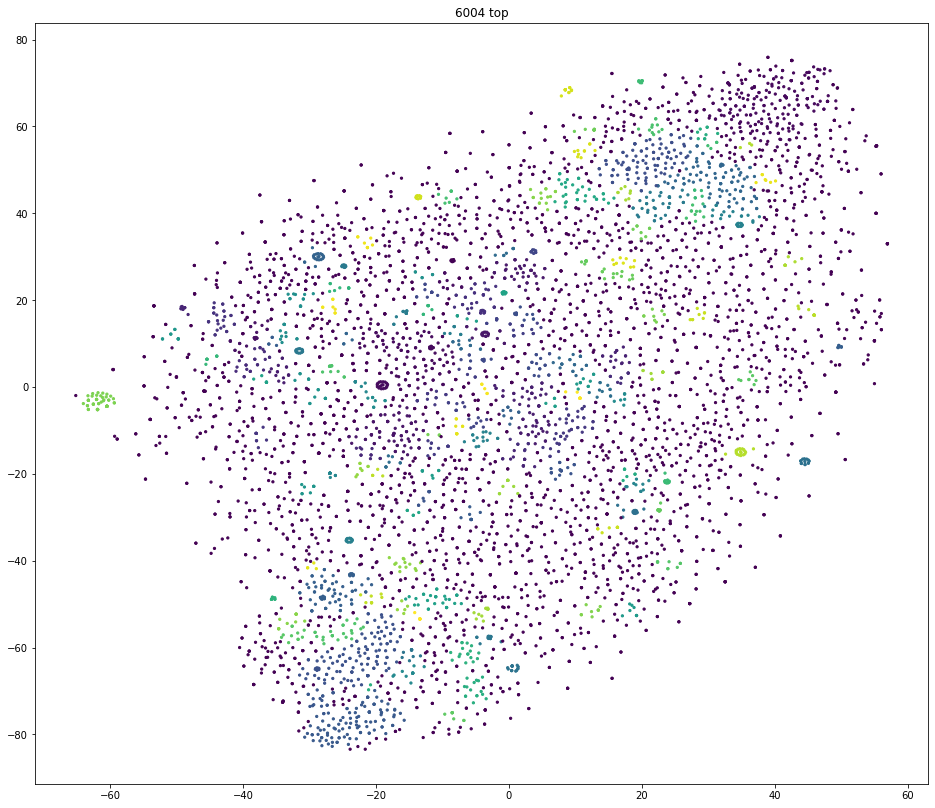

In [126]:
#6004件上身
clustering = DBSCAN(eps=1.8, min_samples=8).fit(top_embedding_tsne)
# clustering.labels_
plt.figure(figsize=(16,14), dpi=72)
plt.title("6004 top")
plt.scatter(top_embedding_tsne[:,0], top_embedding_tsne[:,1], s=5, c=clustering.labels_)
# plt.savefig("/workspace/Yude/OB file/DBscan_clustering/6004top_eps1p8min8.jpg")
plt.show()

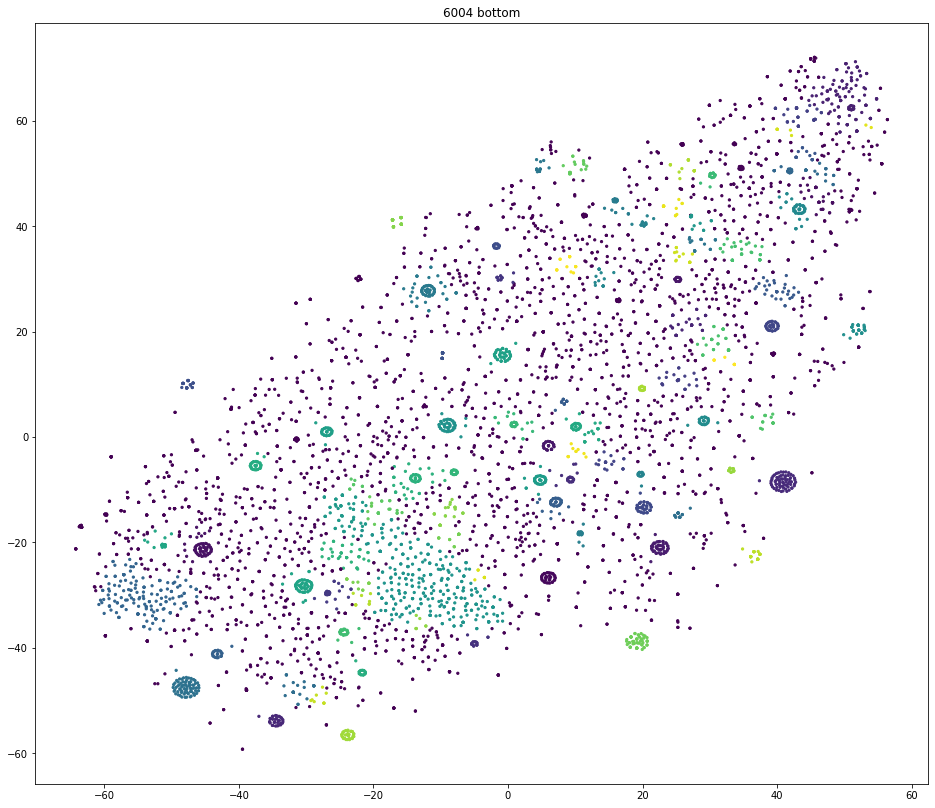

In [151]:
#6004件下身
clustering = DBSCAN(eps=2, min_samples=15).fit(bottom_embedding_tsne)
# clustering.labels_
plt.figure(figsize=(16,14), dpi=72)
plt.title("6004 bottom")
plt.scatter(bottom_embedding_tsne[:,0], bottom_embedding_tsne[:,1], s=5, c=clustering.labels_)
# plt.savefig("/workspace/Yude/OB file/DBscan_clustering/6004bottom_eps2min15.jpg")
plt.show()

### 5066套上身及下身

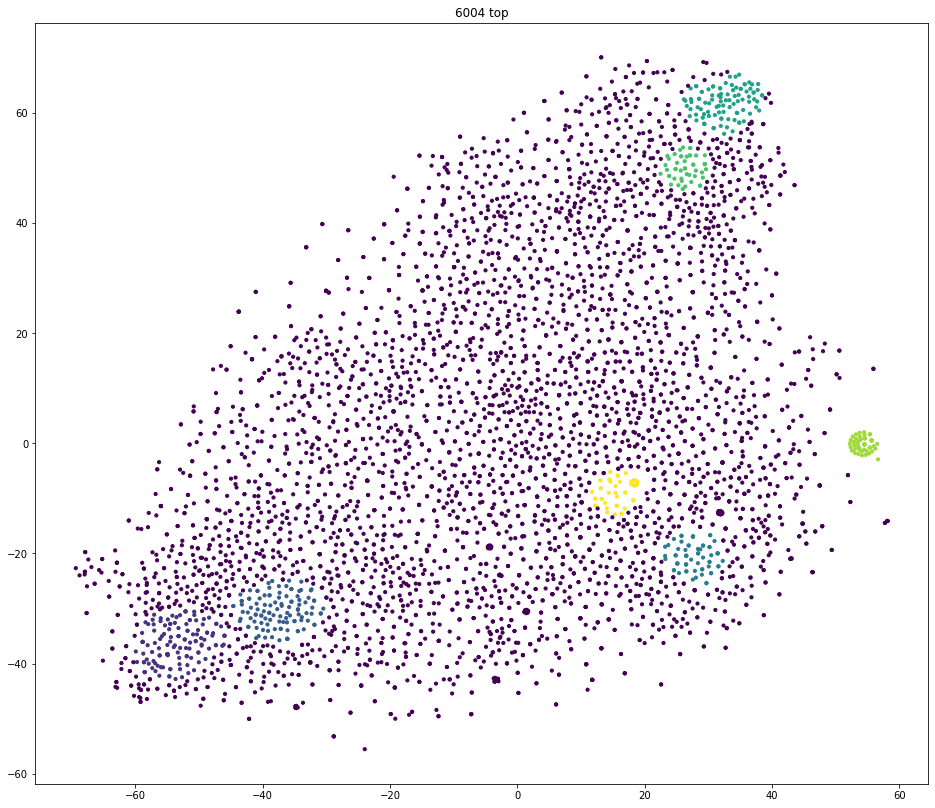

In [276]:
#5066件上身
clustering = DBSCAN(eps=4, min_samples=48).fit(top_embedding_tsne)
# clustering.labels_
plt.figure(figsize=(16,14), dpi=72)
plt.title("6004 top")
plt.scatter(top_embedding_tsne[:,0], top_embedding_tsne[:,1], s=10, c=clustering.labels_)
# plt.savefig("/workspace/Yude/OB file/DBscan_clustering/6004top_eps1p8min8.jpg")
plt.show()

In [ ]:
#5066件下身
clustering = DBSCAN(eps=2, min_samples=15).fit(bottom_embedding_tsne)
# clustering.labels_
plt.figure(figsize=(16,14), dpi=72)
plt.title("6004 bottom")
plt.scatter(bottom_embedding_tsne[:,0], bottom_embedding_tsne[:,1], s=5, c=clustering.labels_)
# plt.savefig("/workspace/Yude/OB file/DBscan_clustering/6004bottom_eps2min15.jpg")
plt.show()

---

## Approximate Nearest Neighbors OH YEAH !

透過先降維再經過ANN

In [14]:
#6004件上下身
# top_embedding_array = np.load("/workspace/Yude/OB file/6004_top_embedding_array.npy")
# bottom_embedding_array = np.load("/workspace/Yude/OB file/6004_bottom_embedding_array.npy")

#5066件上下身
# top_embedding_array = np.load("/workspace/Yude/OB file/5063_top_embedding_array.npy")
# bottom_embedding_array = np.load("/workspace/Yude/OB file/5063_bottom_embedding_array.npy")

#3469件上身 1884件下身
top_embedding_array = np.load("/workspace/Yude/OB file/npy file/resnet80/3469_top_embedding_array.npy")
bottom_embedding_array = np.load("/workspace/Yude/OB file/npy file/resnet80/1884_bottom_embedding_array.npy")

---

## Retrieval雛形測試

以128維embedding 進行ANN

In [16]:
num_dimensions = 128 # embedding總共有多少dimension
num_trees = 50 # Number of trees to build for the index (higher numbers give better accuracy but are slower)
#top, bottom索引庫的設定
top_annoy_index = AnnoyIndex(num_dimensions, 'euclidean') #可以選自己想要的距離計算方式
bottom_annoy_index = AnnoyIndex(num_dimensions, 'euclidean')
#分別新增top, bottom的embedding到索引庫 index只能是數字
for i in range(5063):
    top_annoy_index.add_item(i, top_embedding_array[i])#可以是list或array
    bottom_annoy_index.add_item(i, bottom_embedding_array[i])
#依照前面設定的樹數量建立樹
top_annoy_index.build(num_trees)
bottom_annoy_index.build(num_trees)

IndexError: index 1884 is out of bounds for axis 0 with size 1884

In [18]:
#載入訓練時的模型架構
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        resnet = models.resnet18(pretrained=True)
        resnet.fc = nn.Sequential()
        self.features = resnet
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(True),
            nn.Dropout(),
            nn.Linear(256, 128)
        )
    def forward(self, x):
        #經過ResNet提取特徵
        output = self.features(x)
        #flatten 不同模型 這裡的size不同
        output = output.view((output.size(0)*output.size(1)))
        # 經過fc層
        output = self.fc(output)
        return output
#因為一開始保存的參數是在siamese_net架構下保存的 所以也要定義,然後把其中一個輸入參數設為none才不會出錯
class SiameseNet(nn.Module):
    def __init__(self, EmbeddingNet):
        super(SiameseNet, self).__init__()
        self.EmbeddingNet = EmbeddingNet
        
    def forward(self, x1, x2=None):
        output1 = self.EmbeddingNet(x1)
        # output2 = self.EmbeddingNet(x2)
        return output1#, output2
    
embedding_net = EmbeddingNet()
siamese_net = SiameseNet(embedding_net)
siamese_net.load_state_dict(torch.load("/workspace/Yude/OB file/resnet80relu.pt"))
siamese_net.to("cuda")
siamese_net.eval()
transform = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5,.5,.5],std=[.5,.5,.5])
])

#定義取得query embedding
def get_embedding(img_no):
    query_img_path = f'/workspace/Yude/OB file/@1jpg/{img_no}.jpg'
    query_img = Image.open(query_img_path)
    query_img.resize([300,400]).show()
    query_transform = transform(query_img)
    query_transform_uq = query_transform.unsqueeze(0)
    x = query_transform_uq.cuda()
    query_embedding = siamese_net(x)
    detach_query_embedding = query_embedding.detach().cpu().numpy()
    return detach_query_embedding

mixfitdata_df = pd.read_csv("/workspace/Yude/OB file/csv file/mixFitData.csv",index_col=0)

#取得衣服的款號
def no_gen(top_or_bottom, index):
    if top_or_bottom == "top":
        top_no = mixfitdata_df['Top'].iloc[index]
        return top_no, index
    if top_or_bottom == "bottom":
        bottom_no = mixfitdata_df['Bottom'].iloc[index]
        return bottom_no, index

/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:207: UserWarning: The parameter 'pretrained' is deprecated, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:220: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:03<00:00, 11.7MB/s]


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

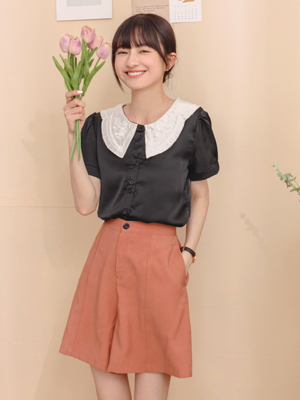

In [26]:
#輸入想要的index 跟query的類別
top_or_bottom = "top"
index = 3000
img_no, index = no_gen(top_or_bottom=top_or_bottom,index=index)
#得到query的embedding
query_embedding = get_embedding(img_no=img_no)

與款號: BA4757 可搭


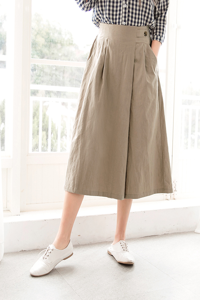

與款號: BA4733 可搭


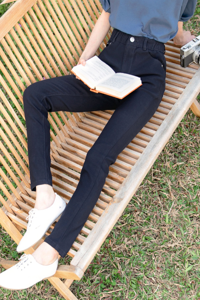

與款號: BA5690 可搭


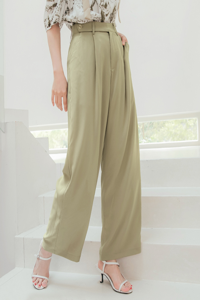

與款號: BA4035 可搭


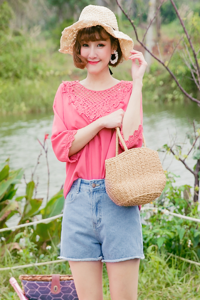

與款號: BA5294 可搭


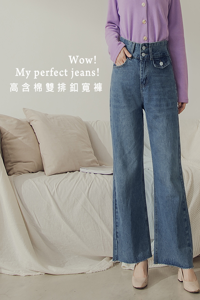

In [27]:
query_vector = query_embedding
num_neighbors = 5 # Number of neighbors to find

#判斷互補的類別
if top_or_bottom == "top":
    comp_annoy_index = bottom_annoy_index
    #後面PCA可視化要用的
    comp_embedding = bottom_embedding_array
    comp_column = "Bottom"
elif top_or_bottom == "bottom":
    comp_annoy_index = top_annoy_index
    comp_embedding = top_embedding_array
    comp_column = "Top"
# Returns a list of IDs of the nearest neighbors to the query vector
nearest_neighbors = comp_annoy_index.get_nns_by_vector(query_vector, num_neighbors)
candidate = []
nodup_candidate = []
for i in nearest_neighbors:
    comp_item = mixfitdata_df[comp_column].loc[i]
    if comp_item not in candidate:
        nodup_candidate.append([i, comp_item])
        candidate.append(comp_item)
for i in nodup_candidate:
    comp_img_path = f'/workspace/Yude/OB file/@1jpg/{i[1]}.jpg'
    complementary_img = Image.open(comp_img_path)
    complementary_img = complementary_img.resize([200,300])
    print(f'與款號: {i[1]} 可搭')
    complementary_img.show()

    

In [28]:
nodup_candidate

[[486, 'BA4757'],
 [487, 'BA4733'],
 [1653, 'BA5690'],
 [1783, 'BA4035'],
 [1830, 'BA5294']]

In [36]:
nearest_neighbors

[978, 1232, 1, 26, 597]

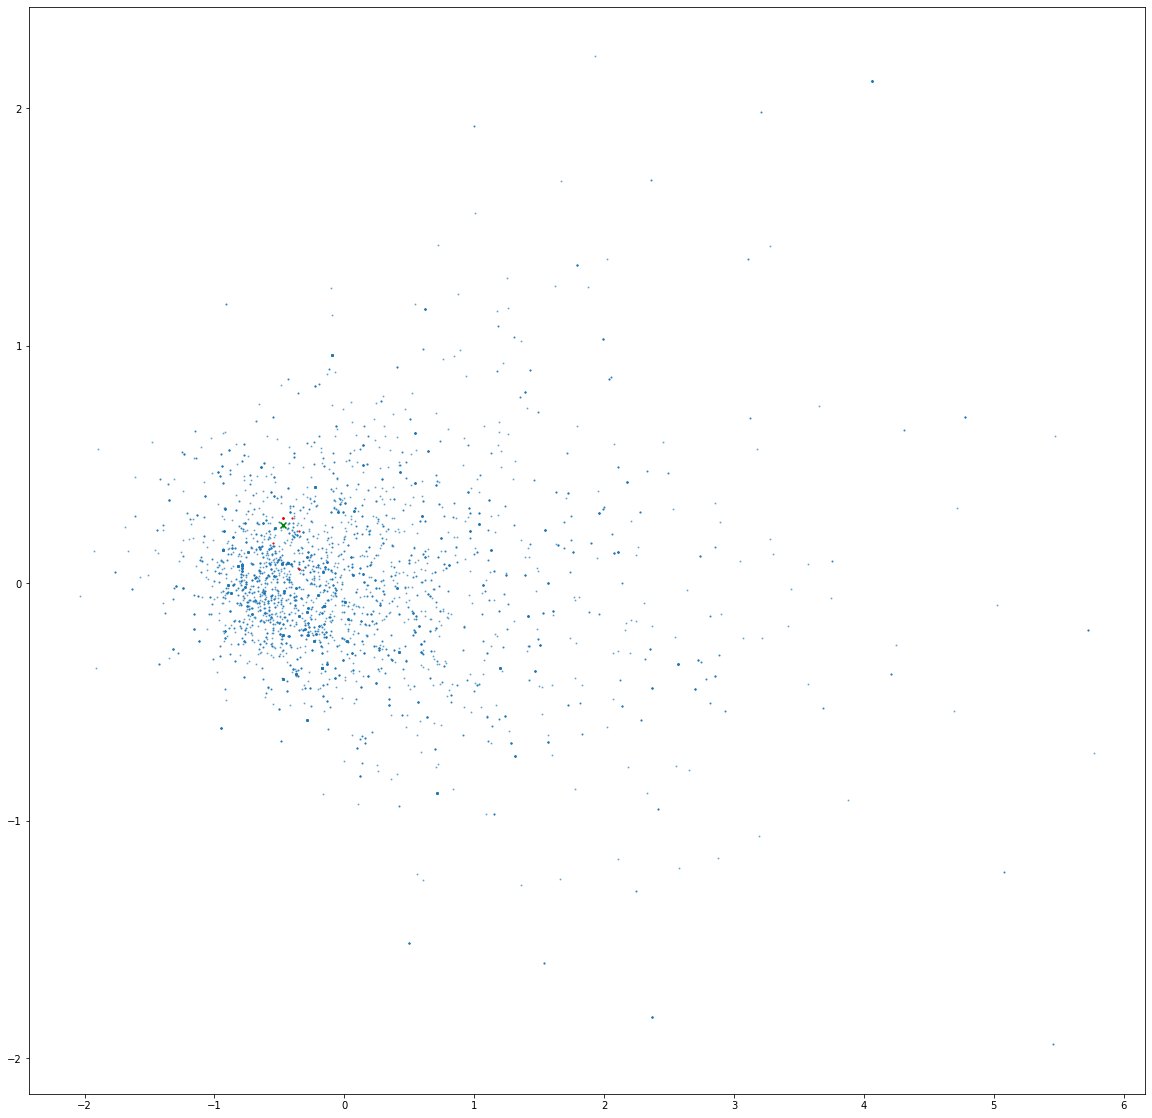

In [303]:
nns_list = [x[0] for x in nodup_candidate]
pca = PCA(n_components=2)
comp_pca = pca.fit_transform(comp_embedding)
q_pca = pca.transform(query_embedding.reshape(1, -1))#要先有上一行的fit_transform才可以叫出transform
# plot the data points and their nearest neighbors
plt.figure(figsize=(20,20), dpi=72)
plt.scatter(comp_pca[:, 0], comp_pca[:, 1], alpha=0.5, s=1)
plt.scatter(comp_pca[nns_list, 0], comp_pca[nns_list, 1], s=1, c='r')
plt.scatter(q_pca[:, 0], q_pca[:, 1], c='g', marker='x')
plt.show()


---

## 生成(3469+1884)*k套的搭配以及item_pair_set.csv

In [49]:
top_embedding_array = np.load("npy file/resnet94v1/3469_top_embedding_array.npy")
bottom_embedding_array = np.load("npy file/resnet94v1/1884_bottom_embedding_array.npy")

In [4]:
#載入訓練時的模型架構
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        resnet = models.resnet18(pretrained=True)
        resnet.fc = nn.Sequential()
        self.features = resnet
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(True),
            nn.Dropout(),
            nn.Linear(256, 128)
        )
    def forward(self, x):
        #經過ResNet提取特徵
        output = self.features(x)
        #flatten 不同模型 這裡的size不同
        output = output.view((output.size(0)*output.size(1)))
        # 經過fc層
        output = self.fc(output)
        return output
#因為一開始保存的參數是在siamese_net架構下保存的 所以也要定義,然後把其中一個輸入參數設為none才不會出錯
class SiameseNet(nn.Module):
    def __init__(self, EmbeddingNet):
        super(SiameseNet, self).__init__()
        self.EmbeddingNet = EmbeddingNet
        
    def forward(self, x1, x2=None):
        output1 = self.EmbeddingNet(x1)
        # output2 = self.EmbeddingNet(x2)
        return output1#, output2
    
embedding_net = EmbeddingNet()
siamese_net = SiameseNet(embedding_net)
siamese_net.load_state_dict(torch.load("/workspace/Yude/OB file/resnet80relu.pt"))
siamese_net.to("cuda")
siamese_net.eval()
transform = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5,.5,.5],std=[.5,.5,.5])
])

#定義取得query embedding
def get_embedding(img_no):
    query_img_path = f'/workspace/Yude/OB file/@1jpg/{img_no}.jpg'
    query_img = Image.open(query_img_path)
    # query_img.resize([300,400]).show()
    query_transform = transform(query_img)
    query_transform_uq = query_transform.unsqueeze(0)
    x = query_transform_uq.cuda()
    query_embedding = siamese_net(x)
    detach_query_embedding = query_embedding.detach().cpu().numpy()
    return detach_query_embedding 

/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:207: UserWarning: The parameter 'pretrained' is deprecated, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:220: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [77]:

top_embedding_array = np.load("npy file/128 dim/resnet_m_1p5/3469_top_embedding_array.npy")
bottom_embedding_array = np.load("npy file/resnet94v1/1884_bottom_embedding_array.npy")

num_dimensions = 128 # embedding總共有多少dimension
num_trees = 50 # Number of trees to build for the index (higher numbers give better accuracy but are slower)
#top, bottom索引庫的設定
top_annoy_index = AnnoyIndex(num_dimensions, 'euclidean') #可以選自己想要的距離計算方式
bottom_annoy_index = AnnoyIndex(num_dimensions, 'euclidean')
#分別新增top, bottom的embedding到索引庫 index只能是數字
for i in range(3469):
    top_annoy_index.add_item(i, top_embedding_array[i])#可以是list或array
for i in range(1884):
    bottom_annoy_index.add_item(i, bottom_embedding_array[i])
#依照前面設定的樹數量建立樹
top_annoy_index.build(num_trees)
bottom_annoy_index.build(num_trees)


num_neighbors = 35
# if os.path.exists("/workspace/Yude/OB file/fit") == False:
#     os.mkdir("/workspace/Yude/OB file/fit")
item_pair_set_df = pd.DataFrame(columns=['head_label','tail_label','head_name','tail_name'])
top_df = pd.read_pickle("pickle file/resnet94v1/3469_top_embedding.pickle")
bottom_df = pd.read_pickle("pickle file/resnet94v1/1884_bottom_embedding.pickle")
file_no = 0
for top_or_bottom in ["top", "bottom"]:
    #判斷互補的類別
    if top_or_bottom == "top":
        comp_annoy_index = bottom_annoy_index
        comp_df = bottom_df
        item_df = top_df
    elif top_or_bottom == "bottom":
        comp_annoy_index = top_annoy_index
        comp_df = top_df
        item_df = bottom_df
    for index,item in tqdm(item_df.iterrows(), total=len(item_df)):
        img_no = item[0]
        query_vector = item[1]#當gpu不可用的時候
        # query_vector = get_embedding(img_no=img_no)
        # Returns a list of IDs of the nearest neighbors to the query vector
        nearest_neighbors = comp_annoy_index.get_nns_by_vector(query_vector, num_neighbors)
        candidate = []
        nodup_candidate = []
        for i in nearest_neighbors:
            comp_item = comp_df['item_no'].loc[i]
            if comp_item not in candidate:
                nodup_candidate.append([i, comp_item])
                candidate.append(comp_item)
        # query_pth = f'/workspace/Yude/OB file/@1jpg/{img_no}.jpg'
        for i in nodup_candidate:
            # if len(str(file_no)) == 1:
            #     fit_name = "fit0000"
            # elif len(str(file_no)) == 2:
            #     fit_name = "fit000"
            # elif len(str(file_no)) == 3:
            #     fit_name = "fit00"
            # elif len(str(file_no)) == 4:
            #     fit_name = "fit0"
            # elif len(str(file_no)) == 5:
            #     fit_name = "fit"
            # os.mkdir(f'/workspace/Yude/OB file/fit/{fit_name}{file_no}')
            # comp_img_path = f'/workspace/Yude/OB file/@1jpg/{i[1]}.jpg'          
            if top_or_bottom == "top":
                # top_target = f'/workspace/Yude/OB file/fit/{fit_name}{file_no}/上身 {img_no}.jpg'
                # bottom_target = f'/workspace/Yude/OB file/fit/{fit_name}{file_no}/下身 {i[1]}.jpg'
                item_pair_set_df.loc[len(item_pair_set_df)] = [img_no, i[1],"上身","下身"]
            elif top_or_bottom == "bottom":
                # top_target = f'/workspace/Yude/OB file/fit/{fit_name}{file_no}/上身 {i[1]}.jpg'
                # bottom_target = f'/workspace/Yude/OB file/fit/{fit_name}{file_no}/下身 {img_no}.jpg'
                item_pair_set_df.loc[len(item_pair_set_df)] = [i[1], img_no,"上身","下身"]
            # shutil.copyfile(query_pth,top_target)
            # shutil.copyfile(comp_img_path,bottom_target)
            # file_no += 1
            

100%|██████████| 1884/1884 [05:09<00:00,  6.08it/s]


In [5]:
margin_list = ["1p5","2","2p5","3"]
num_dimensions_list = [256,512] # embedding總共有多少dimension
num_trees = 50 # Number of trees to build for the index (higher numbers give better accuracy but are slower)
activation_list = ["lrelu","tanh"]

for activation in activation_list:
    for num_dimensions in num_dimensions_list:
        print(f'{num_dimensions} {activation}...')
        for margin in margin_list:
            print(f'margin {margin}')
            top_embedding_array = np.load(f'img and ch label/npy file/{num_dimensions} {activation}/m_{margin}/3469_top_embedding_array.npy')
            bottom_embedding_array = np.load(f'img and ch label/npy file/{num_dimensions} {activation}/m_{margin}/1884_bottom_embedding_array.npy')

            #top, bottom索引庫的設定
            top_annoy_index = AnnoyIndex(num_dimensions, 'euclidean') #可以選自己想要的距離計算方式
            bottom_annoy_index = AnnoyIndex(num_dimensions, 'euclidean')

            #分別新增top, bottom的embedding到索引庫 index只能是數字
            for i in range(3469):
                top_annoy_index.add_item(i, top_embedding_array[i])#可以是list或array
            for i in range(1884):
                bottom_annoy_index.add_item(i, bottom_embedding_array[i])
            #依照前面設定的樹數量建立樹
            top_annoy_index.build(num_trees)
            bottom_annoy_index.build(num_trees)

            # if os.path.exists("/workspace/Yude/OB file/fit") == False:
            #     os.mkdir("/workspace/Yude/OB file/fit")
            item_pair_set_df = pd.DataFrame(columns=['head_label','tail_label','head_name','tail_name'])
            top_df = pd.read_pickle(f'img and ch label/pickle file/{num_dimensions} {activation}/m_{margin}/3469_top_embedding.pickle')
            bottom_df = pd.read_pickle(f'img and ch label/pickle file/{num_dimensions} {activation}/m_{margin}/1884_bottom_embedding.pickle')
            file_no = 0

            num_neighbors = [10, 20, 30, 40, 50]

            for k in num_neighbors:
                item_pair_set_df = pd.DataFrame(columns=['head_label','tail_label','head_name','tail_name'])
                print(f'generating top{k}...')
                for top_or_bottom in ["top", "bottom"]:
                    #判斷互補的類別
                    if top_or_bottom == "top":
                        comp_annoy_index = bottom_annoy_index
                        comp_df = bottom_df
                        item_df = top_df
                    elif top_or_bottom == "bottom":
                        comp_annoy_index = top_annoy_index
                        comp_df = top_df
                        item_df = bottom_df
                    for index,item in tqdm(item_df.iterrows(), total=len(item_df)):
                        img_no = item[0]
                        query_vector = item[1]#當gpu不可用的時候
                        # query_vector = get_embedding(img_no=img_no)
                        # Returns a list of IDs of the nearest neighbors to the query vector
                        nearest_neighbors = comp_annoy_index.get_nns_by_vector(query_vector, k)
                        candidate = []
                        nodup_candidate = []
                        for i in nearest_neighbors:
                            comp_item = comp_df['item_no'].loc[i]
                            if comp_item not in candidate:
                                nodup_candidate.append([i, comp_item])
                                candidate.append(comp_item)
                        # query_pth = f'/workspace/Yude/OB file/@1jpg/{img_no}.jpg'
                        for i in nodup_candidate:
                            # if len(str(file_no)) == 1:
                            #     fit_name = "fit0000"
                            # elif len(str(file_no)) == 2:
                            #     fit_name = "fit000"
                            # elif len(str(file_no)) == 3:
                            #     fit_name = "fit00"
                            # elif len(str(file_no)) == 4:
                            #     fit_name = "fit0"
                            # elif len(str(file_no)) == 5:
                            #     fit_name = "fit"
                            # os.mkdir(f'/workspace/Yude/OB file/fit/{fit_name}{file_no}')
                            # comp_img_path = f'/workspace/Yude/OB file/@1jpg/{i[1]}.jpg'          
                            if top_or_bottom == "top":
                                # top_target = f'/workspace/Yude/OB file/fit/{fit_name}{file_no}/上身 {img_no}.jpg'
                                # bottom_target = f'/workspace/Yude/OB file/fit/{fit_name}{file_no}/下身 {i[1]}.jpg'
                                item_pair_set_df.loc[len(item_pair_set_df)] = [img_no, i[1],"上身","下身"]
                            elif top_or_bottom == "bottom":
                                # top_target = f'/workspace/Yude/OB file/fit/{fit_name}{file_no}/上身 {i[1]}.jpg'
                                # bottom_target = f'/workspace/Yude/OB file/fit/{fit_name}{file_no}/下身 {img_no}.jpg'
                                item_pair_set_df.loc[len(item_pair_set_df)] = [i[1], img_no,"上身","下身"]
                            # shutil.copyfile(query_pth,top_target)
                            # shutil.copyfile(comp_img_path,bottom_target)
                            # file_no += 1
                print(f'should have {5353*k} rows, it have {len(item_pair_set_df)} rows')
                item_pair_set_df.to_csv(f'img and ch label/csv file/{num_dimensions} {activation}/m_{margin}/item_pair_set_top{k}.csv', index=False, encoding='utf-8-sig')
        print("----------------------------------------")
                    

256 lrelu...
margin 1p5
generating top10...


100%|██████████| 1884/1884 [01:11<00:00, 26.45it/s]


should have 53530 rows, it have 53530 rows
generating top20...


100%|██████████| 1884/1884 [03:37<00:00,  8.66it/s]


should have 107060 rows, it have 107060 rows
generating top30...


100%|██████████| 1884/1884 [07:56<00:00,  3.96it/s]


should have 160590 rows, it have 160590 rows
generating top40...


100%|██████████| 1884/1884 [13:54<00:00,  2.26it/s]


should have 214120 rows, it have 214120 rows
generating top50...


 63%|██████▎   | 2190/3469 [07:37<04:27,  4.79it/s]


KeyboardInterrupt: 

### 生成query topk的csv&搭配資料夾

In [5]:
#以retrieval性能較好的模型生成20件衣服的top5 
margin = 3
num_neighbors = 5
num_dimensions = 512 # embedding總共有多少dimension
num_trees = 50 # Number of trees to build for the index (higher numbers give better accuracy but are slower)


print(f'margin {margin}')
top_embedding_array = np.load(f'npy file/{num_dimensions} dim/resnet_m_{margin}/3469_top_embedding_array.npy')
bottom_embedding_array = np.load(f'npy file/{num_dimensions} dim/resnet_m_{margin}/1884_bottom_embedding_array.npy')

#top, bottom索引庫的設定
top_annoy_index = AnnoyIndex(num_dimensions, 'euclidean') #可以選自己想要的距離計算方式
bottom_annoy_index = AnnoyIndex(num_dimensions, 'euclidean')

#分別新增top, bottom的embedding到索引庫 index只能是數字
for i in range(3469):
    top_annoy_index.add_item(i, top_embedding_array[i])#可以是list或array
for i in range(1884):
    bottom_annoy_index.add_item(i, bottom_embedding_array[i])
#依照前面設定的樹數量建立樹
top_annoy_index.build(num_trees)
bottom_annoy_index.build(num_trees)

# if os.path.exists("/workspace/Yude/OB file/fit") == False:
#     os.mkdir("/workspace/Yude/OB file/fit")
item_pair_set_df = pd.DataFrame(columns=['head_label','tail_label','head_name','tail_name'])
top_df = pd.read_pickle(f'pickle file/{num_dimensions} dim/resnet_m_{margin}/3469_top_embedding.pickle')
bottom_df = pd.read_pickle(f'pickle file/{num_dimensions} dim/resnet_m_{margin}/1884_bottom_embedding.pickle')
top_df_sample = top_df.sample(10, random_state=2)
bottom_df_sample = bottom_df.sample(10, random_state=3)
file_no = 0

item_pair_set_df = pd.DataFrame(columns=['head_label','tail_label','head_name','tail_name'])
print(f'generating top{num_neighbors}...')
for top_or_bottom in ["top", "bottom"]:
    #判斷互補的類別
    if top_or_bottom == "top":
        comp_annoy_index = bottom_annoy_index
        comp_df = bottom_df
        item_df = top_df_sample
    elif top_or_bottom == "bottom":
        comp_annoy_index = top_annoy_index
        comp_df = top_df
        item_df = bottom_df_sample
    for index,item in tqdm(item_df.iterrows(), total=len(item_df)):
        img_no = item[0]
        query_vector = item[1]#當gpu不可用的時候
        # query_vector = get_embedding(img_no=img_no)
        # Returns a list of IDs of the nearest neighbors to the query vector
        nearest_neighbors = comp_annoy_index.get_nns_by_vector(query_vector, num_neighbors)
        candidate = []
        nodup_candidate = []
        for i in nearest_neighbors:
            comp_item = comp_df['item_no'].loc[i]
            if comp_item not in candidate:
                nodup_candidate.append([i, comp_item])
                candidate.append(comp_item)
        query_pth = f'@1jpg/{img_no}.jpg'
        for i in nodup_candidate:
            if len(str(file_no)) == 1:
                fit_name = "fit0000"
            elif len(str(file_no)) == 2:
                fit_name = "fit000"
            # elif len(str(file_no)) == 3:
            #     fit_name = "fit00"
            # elif len(str(file_no)) == 4:
            #     fit_name = "fit0"
            # elif len(str(file_no)) == 5:
            #     fit_name = "fit"
            os.mkdir(f'fit/{fit_name}{file_no}')
            comp_img_path = f'@1jpg/{i[1]}.jpg'          
            if top_or_bottom == "top":
                top_target = f'fit/{fit_name}{file_no}/上身 {img_no}.jpg'
                bottom_target = f'fit/{fit_name}{file_no}/下身 {i[1]}.jpg'
                item_pair_set_df.loc[len(item_pair_set_df)] = [img_no, i[1],"上身","下身"]
            elif top_or_bottom == "bottom":
                top_target = f'fit/{fit_name}{file_no}/上身 {i[1]}.jpg'
                bottom_target = f'fit/{fit_name}{file_no}/下身 {img_no}.jpg'
                item_pair_set_df.loc[len(item_pair_set_df)] = [i[1], img_no,"上身","下身"]
            shutil.copyfile(query_pth,top_target)
            shutil.copyfile(comp_img_path,bottom_target)
            file_no += 1
print(f'should have {(len(top_df_sample)+len(bottom_df_sample))*num_neighbors} rows, it have {len(item_pair_set_df)} rows')
item_pair_set_df.to_csv(f'item_pair_set.csv', index=False, encoding='utf-8-sig')
            

margin 3
generating top5...


100%|██████████| 10/10 [00:01<00:00,  7.77it/s]

should have 100 rows, it have 100 rows


In [8]:
comp_df

,item_no,embedding
1259,CA2170,"[-0.051621836, -0.31862718, 0.5908444, -0.1578..."
457,CA1742,"[-0.20994632, -0.57394254, 1.0121166, 0.682304..."
533,BA5223,"[0.8185013, -0.39404717, -0.118473366, 0.61257..."
83,BA5625,"[0.5531447, 0.32770988, 0.38497025, 0.07532698..."
454,DA8885,"[0.8279683, 0.047043525, 0.22652386, 0.8761850..."
1728,DA9005,"[-0.07635869, -0.29517514, 0.20541121, 0.07017..."
1490,BA5179,"[-0.46399298, -0.26611492, 0.31331715, -0.6186..."
146,CA2145,"[0.8261032, -0.20216009, 0.3182864, 0.7578008,..."
1620,DA8974,"[0.9548467, 0.26004565, -0.5440992, -0.1489602..."
1213,BA4837,"[0.17917825, -0.23697233, 0.3577126, 0.0983312..."


### 找同一個點有沒有在多點之間被拉扯

In [2]:
mfd = pd.read_csv("csv file/mixFitData.csv")[:5063]
mfd

,Top,Top_label,款號品類,Bottom,Bottom_label,搭配款品類
0,AB10078,上衣,上衣,BA4933,褲子,褲子
1,AB12878,上衣,上衣,BA5666,褲子,褲子
2,AB12961,上衣,上衣,BA5674,褲子,褲子
3,AB12670,上衣,上衣,BA5684,褲子,褲子
4,AB12295,上衣,上衣,BA5685,褲子,褲子
...,...,...,...,...,...,...
5058,AB17340,NaN,上衣,BA6747,NaN,褲子
5059,AB17376,NaN,上衣,BA6747,NaN,褲子
5060,AB17349,NaN,上衣,BA6780,NaN,褲子
5061,AB17461,NaN,上衣,BA6818,NaN,褲子


In [3]:
top_gr = mfd.groupby('Top')
bottom_gr = mfd.groupby('Bottom')
top_ct_df = pd.DataFrame(top_gr.size(),columns=['count'])
bottom_ct_df = pd.DataFrame(bottom_gr.size(),columns=['count'])


In [4]:
#上身搭配次數
top_ct_df.loc[top_ct_df['count']>5]

,count
Top,
AB10107,6
AB12370,12
AB12889,6
AB14532,8
AB14676,6
AB14749,6
AB14872,9
AB16039,6
AB16173,6


In [15]:
#下身搭配次數
bottom_ct_df.loc[bottom_ct_df['count']>30]

,count
Bottom,
BA4172,33
BA4803,44
BA4886,45
BA4887,32
BA4930,34
BA4931,68
BA5175,42
BA5258,42
BA5496,31


In [66]:
num_dimensions = 512 
num_trees = 50

top_embedding_array = np.load(f'npy file/512 dim/resnet_m_3/3469_top_embedding_array.npy')
bottom_embedding_array = np.load(f'npy file/512 dim/resnet_m_3/1884_bottom_embedding_array.npy')

top_annoy_index = AnnoyIndex(num_dimensions, 'euclidean')
bottom_annoy_index = AnnoyIndex(num_dimensions, 'euclidean')

for i in range(3469):
        top_annoy_index.add_item(i, top_embedding_array[i])
for i in range(1884):
    bottom_annoy_index.add_item(i, bottom_embedding_array[i])
    
#依照前面設定的樹數量建立樹
top_annoy_index.build(num_trees)
bottom_annoy_index.build(num_trees)

True

In [141]:
no = "AB12844"
top_or_bottom = "top"
k = 1630
top_df = pd.read_pickle(f'pickle file/512 dim/resnet_m_3/3469_top_embedding.pickle')
bottom_df = pd.read_pickle(f'pickle file/512 dim/resnet_m_3/1884_bottom_embedding.pickle')

if top_or_bottom == "top":
    comp_annoy_index = bottom_annoy_index
    comp_df = bottom_df
    item_df = top_df
elif top_or_bottom == "bottom":
    comp_annoy_index = top_annoy_index
    comp_df = top_df
    item_df = bottom_df
query_index = item_df.loc[item_df['item_no']==no].index[0]
img_no = item_df.loc[query_index][0]
query_vector = item_df.loc[query_index][1]
nearest_neighbors = comp_annoy_index.get_nns_by_vector(query_vector, k , include_distances=True)

In [6]:
#query
img_no

'AB12844'

In [142]:
k = 1
nb = []
for idx, i in enumerate(nearest_neighbors[0]):
    print(f'top{k} {comp_df.loc[i][0]} 與 query {img_no} 的距離為 {nearest_neighbors[1][idx]}')
    nb.append(comp_df.loc[i][0])
    k += 1

top1 DA3537 與 query AB12844 的距離為 8.120827674865723
top2 CA1484 與 query AB12844 的距離為 8.351081848144531
top3 CA2039 與 query AB12844 的距離為 8.590470314025879
top4 BA5416 與 query AB12844 的距離為 8.682234764099121
top5 BA5630 與 query AB12844 的距離為 8.781412124633789
top6 BA5818 與 query AB12844 的距離為 8.862855911254883
top7 CA2079 與 query AB12844 的距離為 8.95195484161377
top8 BA5606 與 query AB12844 的距離為 8.982852935791016
top9 CA1965 與 query AB12844 的距離為 9.003920555114746
top10 BA4168 與 query AB12844 的距離為 9.07890510559082
top11 BA4873 與 query AB12844 的距離為 9.159714698791504
top12 CA1976 與 query AB12844 的距離為 9.1668701171875
top13 DA8574 與 query AB12844 的距離為 9.330703735351562
top14 BA5652 與 query AB12844 的距離為 9.360532760620117
top15 BA5618 與 query AB12844 的距離為 9.36401081085205
top16 CA1887 與 query AB12844 的距離為 9.438087463378906
top17 BA5739 與 query AB12844 的距離為 9.454134941101074
top18 BA5143 與 query AB12844 的距離為 9.45835018157959
top19 BA5385 與 query AB12844 的距離為 9.519217491149902
top20 CA2022 與 query AB1284

In [143]:
"BA5624" in nb

True

In [72]:
mixfitdata = pd.read_csv("csv file/mixFitData.csv")[:5063]
mixfitdata = mixfitdata[['Top', 'Bottom']]
top_ans_gr = mixfitdata.groupby('Top')
bottom_ans_gr = mixfitdata.groupby('Bottom')
top_ans_keys = list(top_ans_gr.groups.keys())
bottom_ans_keys = list(bottom_ans_gr.groups.keys())

In [9]:
if top_or_bottom == "top":
    comp_gr = bottom_ans_gr
    query_gr = top_ans_gr
elif top_or_bottom == "bottom":
    comp_gr = top_ans_gr
    query_gr = bottom_ans_gr
comp = query_gr.get_group(img_no)


In [10]:
#query原本的正確答案
comp

,Top,Bottom
358,AB12844,BA5624
2162,AB12844,BA5624


In [11]:
#其中一個正確答案 被標注可以搭的其他衣服
comp_comp = comp_gr.get_group("BA5624") 
comp_comp

,Top,Bottom
355,AB12781,BA5624
356,AB12782,BA5624
358,AB12844,BA5624
361,AB12922,BA5624
363,AB12964,BA5624
...,...,...
3152,AB13496,BA5624
3164,AB13227,BA5624
3194,AB13497,BA5624
3196,AB13161,BA5624


In [12]:
#query跟正確答案的距離 與 正確答案跟正確答案本來與其他可以搭的標籤的距離相比 看是否有拉扯
if top_or_bottom == "top":
    col = "Bottom"
    comp_comp_col = "Top"
elif top_or_bottom == "bottom":
    col = "Top"
    comp_comp_col = "Bottom"
#query與正確答案的距離
query_v = item_df['embedding'].loc[item_df['item_no'] == img_no].item()

for i in list(set(comp[col])):
    comp_v = comp_df['embedding'].loc[comp_df['item_no'] == i].item()
    dist = np.sqrt(np.sum(np.square(query_v-comp_v)))
    print(f'query {img_no} 與其中一個真實答案 {i} 的距離為 {dist} ')
    #正確答案與正確答案本來與其他可以搭的標籤距離
    for j in list(set(comp_comp[comp_comp_col])):
        comp_comp_v = item_df['embedding'].loc[item_df['item_no'] == j].item()
        dist = np.sqrt(np.sum(np.square(comp_v-comp_comp_v)))
        print(f'真實答案 {i} 與其互補的標籤 {j} 距離為 {dist}')
    print("----------------------------------------------------------------------------")


query AB12844 與其中一個真實答案 BA5624 的距離為 0.5698325037956238 
真實答案 BA5624 與其互補的標籤 AB13003 距離為 0.9966009855270386
真實答案 BA5624 與其互補的標籤 AB12346 距離為 0.6371994018554688
真實答案 BA5624 與其互補的標籤 AB12964 距離為 0.6976151466369629
真實答案 BA5624 與其互補的標籤 AB12767 距離為 0.6362592577934265
真實答案 BA5624 與其互補的標籤 AB12945 距離為 0.8233856558799744
真實答案 BA5624 與其互補的標籤 AB13227 距離為 0.48705798387527466
真實答案 BA5624 與其互補的標籤 AB13086 距離為 0.7747591137886047
真實答案 BA5624 與其互補的標籤 AB12904 距離為 0.5814301371574402
真實答案 BA5624 與其互補的標籤 AB12844 距離為 0.5698325037956238
真實答案 BA5624 與其互補的標籤 AB12970 距離為 0.9445561170578003
真實答案 BA5624 與其互補的標籤 AB13496 距離為 0.5846233367919922
真實答案 BA5624 與其互補的標籤 AB13144 距離為 0.652010440826416
真實答案 BA5624 與其互補的標籤 AB13485 距離為 0.5837794542312622
真實答案 BA5624 與其互補的標籤 AB12845 距離為 0.5942603349685669
真實答案 BA5624 與其互補的標籤 AB13048 距離為 0.5754268765449524
真實答案 BA5624 與其互補的標籤 AB13034 距離為 0.8912460207939148
真實答案 BA5624 與其互補的標籤 AB13051 距離為 0.6353625059127808
真實答案 BA5624 與其互補的標籤 AB13037 距離為 0.6488016247749329
真實答案 BA5624 與其互補的標籤 AB1297

### 生成ppt要用的我的top10 與OB原本的標籤 做對比

In [2]:
#以retrieval性能較好的模型生成20件衣服的top10
margin = 3
num_neighbors = 10
num_dimensions = 512 # embedding總共有多少dimension
num_trees = 50 # Number of trees to build for the index (higher numbers give better accuracy but are slower)


print(f'margin {margin}')
top_embedding_array = np.load(f'npy file/{num_dimensions} dim/resnet_m_{margin}/3469_top_embedding_array.npy')
bottom_embedding_array = np.load(f'npy file/{num_dimensions} dim/resnet_m_{margin}/1884_bottom_embedding_array.npy')

#top, bottom索引庫的設定
top_annoy_index = AnnoyIndex(num_dimensions, 'euclidean') #可以選自己想要的距離計算方式
bottom_annoy_index = AnnoyIndex(num_dimensions, 'euclidean')

#分別新增top, bottom的embedding到索引庫 index只能是數字
for i in range(3469):
    top_annoy_index.add_item(i, top_embedding_array[i])#可以是list或array
for i in range(1884):
    bottom_annoy_index.add_item(i, bottom_embedding_array[i])
#依照前面設定的樹數量建立樹
top_annoy_index.build(num_trees)
bottom_annoy_index.build(num_trees)

top_df = pd.read_pickle(f'pickle file/{num_dimensions} dim/resnet_m_{margin}/3469_top_embedding.pickle')
bottom_df = pd.read_pickle(f'pickle file/{num_dimensions} dim/resnet_m_{margin}/1884_bottom_embedding.pickle')
top_df_sample = top_df.sample(10, random_state=10)
bottom_df_sample = bottom_df.sample(10, random_state=10)

os.mkdir(f'query top{num_neighbors}')
item_pair_set_df = pd.DataFrame(columns=['head_label','tail_label','head_name','tail_name'])
print(f'generating top{num_neighbors}...')
for top_or_bottom in ["top", "bottom"]:
    #判斷互補的類別
    if top_or_bottom == "top":
        comp_annoy_index = bottom_annoy_index
        comp_df = bottom_df
        item_df = top_df_sample
    elif top_or_bottom == "bottom":
        comp_annoy_index = top_annoy_index
        comp_df = top_df
        item_df = bottom_df_sample
    for index,item in tqdm(item_df.iterrows(), total=len(item_df)):
        img_no = item[0]
        query_vector = item[1]#當gpu不可用的時候
        # query_vector = get_embedding(img_no=img_no)
        # Returns a list of IDs of the nearest neighbors to the query vector
        nearest_neighbors = comp_annoy_index.get_nns_by_vector(query_vector, num_neighbors)
        candidate = []
        nodup_candidate = []
        for i in nearest_neighbors:
            comp_item = comp_df['item_no'].loc[i]
            if comp_item not in candidate:
                nodup_candidate.append([i, comp_item])
                candidate.append(comp_item)
        os.mkdir(f'query top{num_neighbors}/{top_or_bottom} query {img_no}')
        query_pth = f'@1jpg/{img_no}.jpg'
        for i in nodup_candidate:
            comp_img_path = f'@1jpg/{i[1]}.jpg'          
            if top_or_bottom == "top":
                top_target = f'query top{num_neighbors}/{top_or_bottom} query {img_no}/query {img_no}.jpg'
                bottom_target = f'query top{num_neighbors}/{top_or_bottom} query {img_no}/下身 {i[1]}.jpg'
                item_pair_set_df.loc[len(item_pair_set_df)] = [img_no, i[1],"上身","下身"]
            elif top_or_bottom == "bottom":
                top_target = f'query top{num_neighbors}/{top_or_bottom} query {img_no}/上身 {i[1]}.jpg'
                bottom_target = f'query top{num_neighbors}/{top_or_bottom} query {img_no}/query {img_no}.jpg'
                item_pair_set_df.loc[len(item_pair_set_df)] = [i[1], img_no,"上身","下身"]
            shutil.copyfile(query_pth,top_target)
            shutil.copyfile(comp_img_path,bottom_target)
            

margin 3
generating top10...


100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


In [12]:
mixfitdata = pd.read_csv("csv file/mixFitData.csv")[:5063]
mixfitdata = mixfitdata[['Top', 'Bottom']]
top_ans_gr = mixfitdata.groupby('Top')
bottom_ans_gr = mixfitdata.groupby('Bottom')
# top_ans_keys = list(top_ans_gr.groups.keys())
# bottom_ans_keys = list(bottom_ans_gr.groups.keys())

In [13]:
os.mkdir("query true answer")
for top_or_bottom in ["top", "bottom"]:
    if top_or_bottom == "top":
        ans_gr = top_ans_gr
        comp_col = "Bottom"
        item_df = top_df_sample
    elif top_or_bottom == "bottom":
        ans_gr = bottom_ans_gr
        comp_col = "Top"
        item_df = bottom_df_sample
    for query in tqdm(item_df['item_no'], total=len(item_df)):
        true_ans_df = ans_gr.get_group(query)
        
        os.mkdir(f'query true answer/{top_or_bottom} query {query}')
        query_pth = f'@1jpg/{query}.jpg'
        for ans in true_ans_df[comp_col]:
            comp_img_path = f'@1jpg/{ans}.jpg'
            if top_or_bottom == "top":
                top_target = f'query true answer/{top_or_bottom} query {query}/query {query}.jpg'
                bottom_target = f'query true answer/{top_or_bottom} query {query}/下身 {ans}.jpg'
            elif top_or_bottom == "bottom":
                top_target = f'query true answer/{top_or_bottom} query {query}/上身 {ans}.jpg'
                bottom_target = f'query true answer/{top_or_bottom} query {query}/query {query}.jpg'
            shutil.copyfile(query_pth,top_target)
            shutil.copyfile(comp_img_path,bottom_target)

100%|██████████| 10/10 [00:00<00:00, 13.41it/s]


In [7]:
# #保存建好的index
# top_annoy_index.save("/workspace/Yude/OB file/ann file/top_annoy_index.ann",prefault=False)
# bottom_annoy_index.save("/workspace/Yude/OB file/ann file/bottom_annoy_index.ann",prefault=False)

True

In [ ]:
# #load先前建立好的index
# top_annoy_index = AnnoyIndex(num_dimensions, 'euclidean')
# top_annoy_index.load("/workspace/Yude/OB file/ann file/top_annoy_index.ann",prefault=False)#prefault是true的話 會直接讀到ram裏面

# bottom_annoy_index = AnnoyIndex(num_dimensions, 'euclidean')
# bottom_annoy_index.load("/workspace/Yude/OB file/ann file/bottom_annoy_index.ann",prefault=False)